In [456]:
!pip install pyathena


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [457]:
from pyathena import connect
import pandas as pd

In [458]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'viamericas'
database_name2= 'analytics'
table1_name = 'forex_feed_market'
table2_name = 'daily_check'
##DAILY CHECK IS THE DATABASE VALIDATED WITH THE CLIENT, IT DOES NOT COUNT CANCELLATIONS OR VIRTUAL AGENCIES##

In [459]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
#df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table1_name};', conn)
df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name2}.{table2_name};', conn)

In [460]:
df2.shape

(101970, 6)

In [461]:
df2.head()

,payer,country,date,tx,amount,coupon_count
0,BANCO AGRICOLA,EL SALVADOR,2021-06-17,707,198615.00,316
1,CHEDRAUI (APPRIZA),MEXICO,2021-06-17,32,17128.00,12
2,24XORO,MEXICO,2023-07-03,53,37002.37,1
3,BANCO DE GUAYAQUIL,ECUADOR,2022-08-16,105,54357.65,1
4,TELECOMM TELEGRAFOS (APPRIZA),MEXICO,2021-11-12,696,391240.62,73


In [447]:
df2['coupon_percent']=(df2.coupon_count/df2.tx)

In [448]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101970 entries, 0 to 101969
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   payer           101970 non-null  object 
 1   country         101970 non-null  object 
 2   date            101970 non-null  object 
 3   tx              101970 non-null  int64  
 4   amount          101970 non-null  float64
 5   coupon_count    101970 non-null  int64  
 6   coupon_percent  93331 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 5.4+ MB


In [210]:
control=df2[df2['coupon_count']>df2['tx']]

In [211]:
control.shape

(725, 7)

In [212]:
##REVISAR ESTOS CASOS DE ARRIBA##

In [213]:
## IMPUTE MISSINGS AND INFS
df2['coupon_percent']=df2['coupon_percent'].fillna(0)

In [214]:
import numpy as np
df2['coupon_percent'] = df2.coupon_percent.replace([np.inf, -np.inf], 0)

In [215]:
df2.head(3)

,payer,country,date,tx,amount,coupon_count,coupon_percent
0,TELECOMM TELEGRAFOS (APPRIZA),MEXICO,2023-04-24,977,536661.67,22,0.022518
1,ELEKTRA (BTS),GUATEMALA,2021-02-27,157,24916.09,121,0.770701
2,OXXO (TN),MEXICO,2021-10-05,210,15696.39,37,0.176190


In [216]:
df2.coupon_percent.min(), df2.coupon_percent.max()

(0.0, 5.0)

In [217]:
df2['coupon_percent'].quantile(0.995)

1.0

In [218]:
##IMPUTAMOS 1 CUANDO ES MAYOR QUE 1 EL RATIO PARA OBSERVAR CUANTO SESGAS LOS PRONÓSTICOS ESTOS "OUTLIERS (no se observan diferencias en uno u otro caso)"
cond = df2['coupon_percent'] > 1
df2.loc[cond, 'coupon_percent'] = 1
df2.coupon_percent.max()

1.0

In [219]:
df1.head()

,symbol,feed_source,feed_time,feed_date,feed_bid,feed_id,feed_ask,feed_remaining,feed_price,day
0,USDBRL,https://api.currencylayer.com/CHANGE,45006,2023-03-23 01:00:28,5.2376,3282071,5.2371,45006,5.2373,2023-03-23
1,USDINR,https://api.currencylayer.com/CHANGE,45006,2023-03-23 01:00:28,82.5260,3282072,82.2440,45006,82.3850,2023-03-23
2,USDGTQ,https://api.currencylayer.com/CHANGE,45006,2023-03-23 01:00:28,7.7997,3282073,7.7997,45006,7.7997,2023-03-23
3,USDMXN,https://api.currencylayer.com/CHANGE,45006,2023-03-23 01:00:28,18.6009,3282074,18.5322,45006,18.5665,2023-03-23
4,USDPHP,https://api.currencylayer.com/CHANGE,45006,2023-03-23 01:00:28,54.4202,3282075,54.4425,45006,54.4313,2023-03-23


In [220]:
##TO SPEED UP THE LOADING, WE ALREADY WORK WITH THE EXTRACTED CSV##

In [221]:
#df1=pd.read_csv('rates_completo.csv')

In [222]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4010720 entries, 0 to 4010719
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   symbol          object        
 1   feed_source     object        
 2   feed_time       object        
 3   feed_date       datetime64[ns]
 4   feed_bid        float64       
 5   feed_id         int64         
 6   feed_ask        float64       
 7   feed_remaining  object        
 8   feed_price      float64       
 9   day             object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 306.0+ MB


In [223]:
df1.symbol.unique()

array(['USDBRL', 'USDINR', 'USDGTQ', 'USDMXN', 'USDPHP'], dtype=object)

In [224]:
##WE FILTER DATA FOR MEXICO##

In [225]:
df_mex=df1.loc[df1.symbol=='USDMXN']

In [226]:
##WE OBTAIN THE LAST VALUE OF THE EXCHANGE RATE OF EACH DAY ##

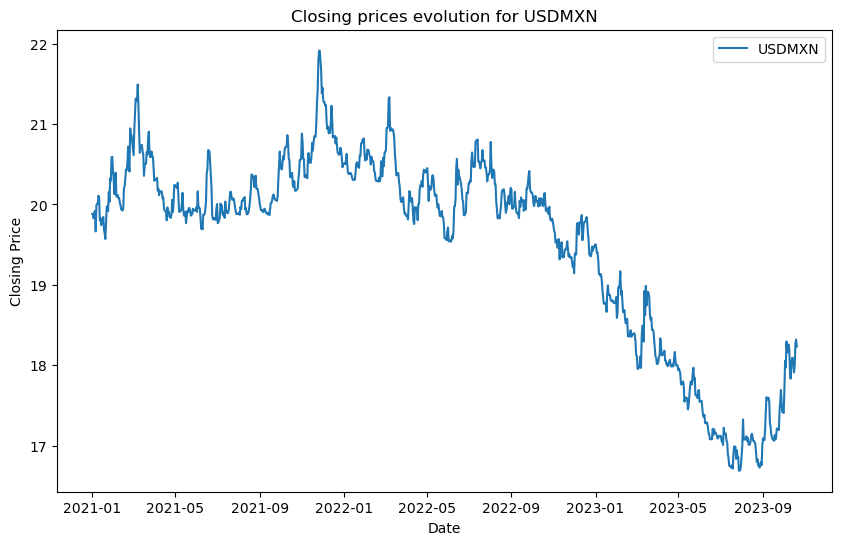

      symbol  feed_date  feed_price
0     USDMXN 2021-01-01     19.8822
1     USDMXN 2021-01-02     19.8822
2     USDMXN 2021-01-03     19.8282
3     USDMXN 2021-01-04     19.9046
4     USDMXN 2021-01-05     19.9196
...      ...        ...         ...
1018  USDMXN 2023-10-16     17.9119
1019  USDMXN 2023-10-17     18.0094
1020  USDMXN 2023-10-18     18.2726
1021  USDMXN 2023-10-19     18.3207
1022  USDMXN 2023-10-20     18.2351

[1023 rows x 3 columns]


In [227]:
import pandas as pd
import matplotlib.pyplot as plt

def get_closing_prices(data, start_date, end_date):
    # Convert the 'FEED_DATE' column to datetime type if it is not already
    data['feed_date'] = pd.to_datetime(data['feed_date'])

    # Filter by date range
    data_filtered = data[(data['feed_date'] >= start_date) & (data['feed_date'] <= end_date)]

    # Sort by 'FEED_DATE' to ensure that the data is in chronological order
    data_filtered = data_filtered.sort_values(by='feed_date')

    # Group by 'SYMBOL' and 'FEED_DATE', taking the last value of 'FEED_PRICE'
    data_grouped = data_filtered.groupby(['symbol', pd.Grouper(key='feed_date', freq='D')])['feed_price'].last().reset_index()

    # Generate evolution plots for each SYMBOL
    for symbol in data_grouped['symbol'].unique():
        symbol_data = data_grouped[data_grouped['symbol'] == symbol]

        plt.figure(figsize=(10, 6))
        plt.plot(symbol_data['feed_date'], symbol_data['feed_price'], label=symbol)
        plt.title(f'Closing prices evolution for {symbol}')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()

    return data_grouped

# Using the function
# Suppose your DataFrame is named df
# Adjust the dates according to your needs
start_date = '2021-01-01'
end_date = '2023-10-21'

rates = get_closing_prices(df_mex, start_date, end_date)
print(rates)

In [228]:
rates.feed_date.nunique()

1023

In [229]:
fecha_inicio = pd.to_datetime('2021-01-01')
fecha_fin = pd.to_datetime('2023-10-21')

# Calcula la diferencia en días
diferencia_dias = (fecha_fin - fecha_inicio).days
print(diferencia_dias)

1023


In [230]:
rates.head(50)

,symbol,feed_date,feed_price
0,USDMXN,2021-01-01,19.8822
1,USDMXN,2021-01-02,19.8822
2,USDMXN,2021-01-03,19.8282
3,USDMXN,2021-01-04,19.9046
4,USDMXN,2021-01-05,19.9196
5,USDMXN,2021-01-06,19.6648
6,USDMXN,2021-01-07,19.9889
7,USDMXN,2021-01-08,20.0041
8,USDMXN,2021-01-09,20.0093
9,USDMXN,2021-01-10,20.1087


In [231]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101970 entries, 0 to 101969
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   payer           101970 non-null  object 
 1   country         101970 non-null  object 
 2   date            101970 non-null  object 
 3   tx              101970 non-null  int64  
 4   amount          101970 non-null  float64
 5   coupon_count    101970 non-null  int64  
 6   coupon_percent  101970 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 5.4+ MB


In [232]:
df2.amount.sum()

25110624454.4149

In [233]:
df2['date'] = pd.to_datetime(df2['date'])

In [234]:
##WE MERGE THE DATASETS TO HAVE TRADED AMOUNTS AND EXCHANGE RATES PER DAY##

In [235]:
rates = rates.rename(columns={'feed_date': 'date'})
rates['date'] = pd.to_datetime(rates['date'])

rates.head()

,symbol,date,feed_price
0,USDMXN,2021-01-01,19.8822
1,USDMXN,2021-01-02,19.8822
2,USDMXN,2021-01-03,19.8282
3,USDMXN,2021-01-04,19.9046
4,USDMXN,2021-01-05,19.9196


In [236]:
###WE OBTAIN THE LAGS OF UP TO 7 DAYS FOR THE EXCHANGE RATE 

In [237]:
for i in range(1, 8):
        nombre_columna = f'feed_price_retardo_{i}'
        rates[nombre_columna] = rates['feed_price'].shift(i)

In [238]:
rates.head(3)

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
0,USDMXN,2021-01-01,19.8822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USDMXN,2021-01-02,19.8822,19.8822,NaN,NaN,NaN,NaN,NaN,NaN
2,USDMXN,2021-01-03,19.8282,19.8822,19.8822,NaN,NaN,NaN,NaN,NaN


In [239]:
##FILTERING MEXICO##

In [240]:
df_montos_mex=df2.loc[df2.country=='MEXICO']

In [241]:
df_montos_mex.shape

(22705, 7)

In [242]:
df_montos_mex.amount.sum()

13655009099.176899

In [243]:
###WE MERGE THE RESULTING DATABASE WITH THE DATABASE OF RATES##

In [244]:
df_final=pd.merge(df_montos_mex, rates, on='date', how='left')

In [245]:
df_final.head(3)

,payer,country,date,tx,amount,coupon_count,coupon_percent,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
0,TELECOMM TELEGRAFOS (APPRIZA),MEXICO,2023-04-24,977,536661.67,22,0.022518,USDMXN,17.9873,18.0096,17.9864,17.9864,17.9989,18.0684,18.0468,18.0294
1,OXXO (TN),MEXICO,2021-10-05,210,15696.39,37,0.176190,USDMXN,20.6024,20.5242,20.4351,20.4509,20.4509,20.6582,20.4948,20.3244
2,TRANSFER DIRECTO,MEXICO,2023-08-12,123,80301.68,2,0.016260,USDMXN,17.0129,17.0129,17.0960,17.0592,17.1183,17.0969,17.0776,17.0785


In [246]:
##AS PART OF A PILOT TEST WE WILL ONLY WORK WITH ONE PAYER, AND THEN WE WILL GENERALIZE THE ROUTINE##
## WE WILL NOW FIT A MODEL WITH LAGS OF THE EXCHANGE RATE (SARIMAX) TO SEE IF IT PERFORMS BETTER THAN THE SIMPLE ARIMA MODEL.
##WE START WITH ELEKTRA AND THE CASE WITHOUT EXOGENOUS VARIABLES ##
df_pilot=df_final.loc[df_final.payer=='ELEKTRA (MEXICO)']
df_pilot.shape

(1025, 16)

In [247]:
##SALES EVOLUTION GRAPH

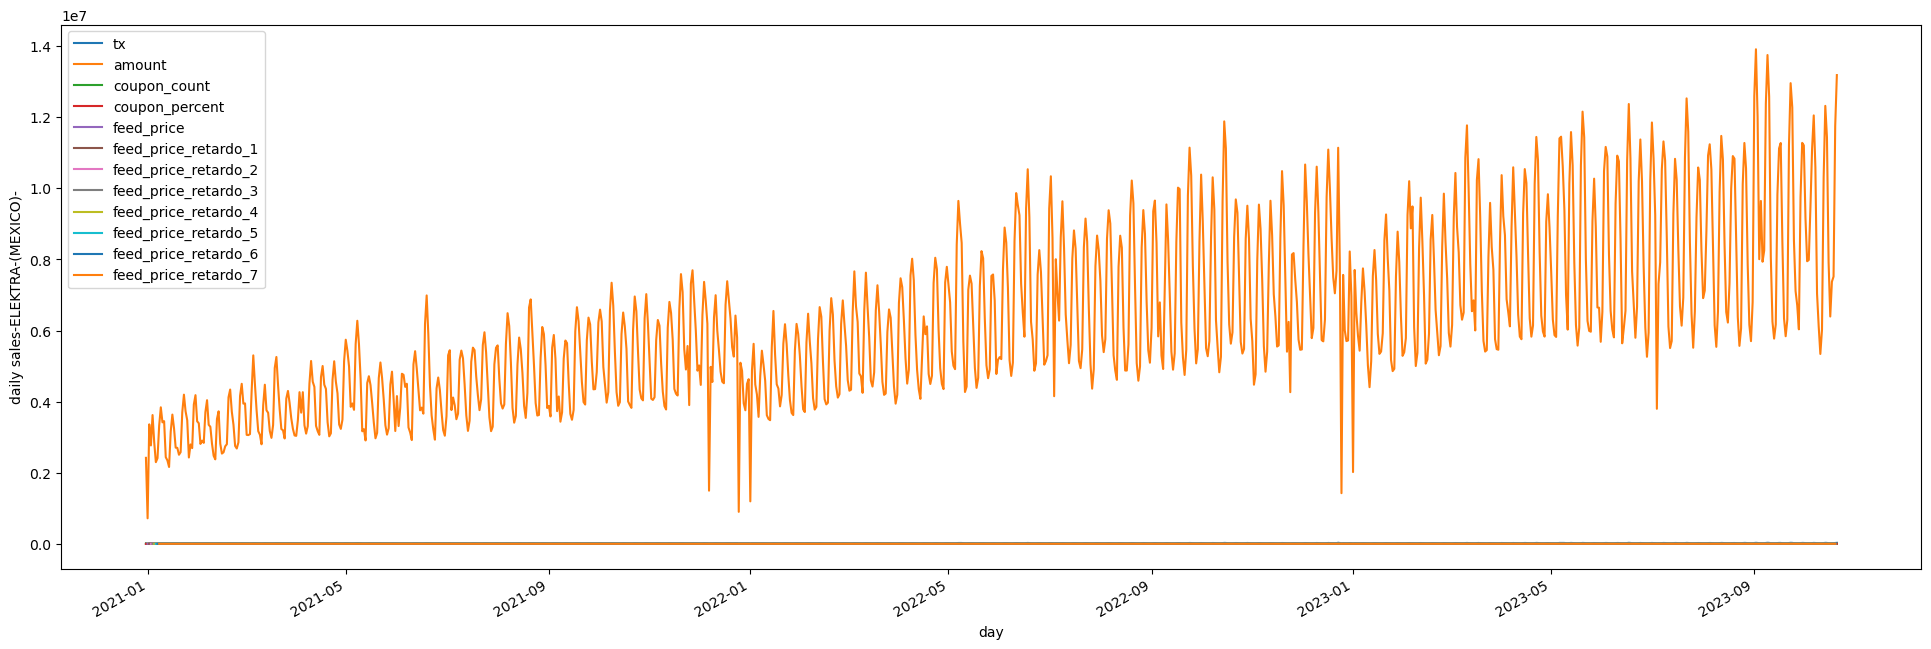

In [248]:
ax = df_pilot.set_index('date').plot(figsize=(24, 8))
ax.set_ylabel('daily sales-ELEKTRA-(MEXICO)-')
ax.set_xlabel('day')
plt.show()

In [249]:
##TIME SERIES FORMAT
data = df_pilot
data.dtypes #day object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot.dtypes   # datetime64[ns]

data.index  #RangeIndex()
data = data.set_index('date')

In [250]:
##WE ELIMINATE STRING VARIABLES AND OTHER VARIABLES##
data=data.loc[:,['amount']]

In [251]:
data = data.sort_values(by='date')

In [252]:
data.head(3)

,amount
date,
2020-12-31,2418346.71
2021-01-01,717241.42
2021-01-02,3360407.85


In [253]:
##WE DECOMPOSE THE SERIES INTO TREND, SEASONALITY AND RESIDUALS

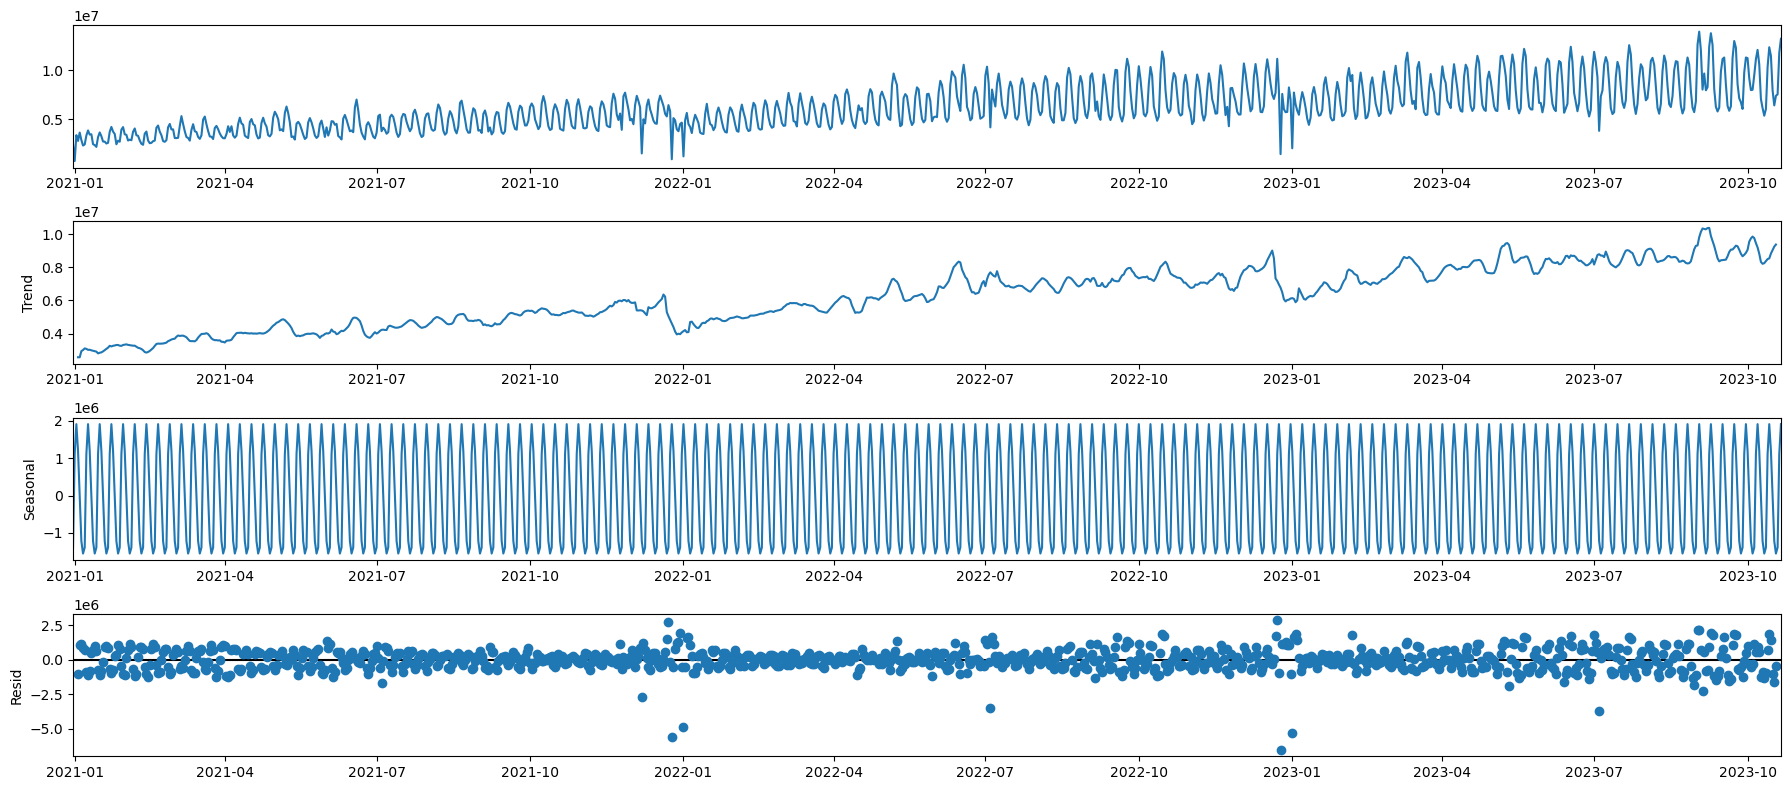

In [254]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=None) #multiplicative, additive
fig = decomposition.plot()
plt.show()

In [255]:
##STATIONARITY TESTS AUTOCORRELATION GRAPHS
##NON-STATIONARY SERIES##
##The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. 
##If the pvalue is above a critical size, then we cannot reject that there is a unit root.
##In this case (ELEKTRA MÉXICO) we check that the series is non-stationary (0.58>0.05)

ADF Statistic: -1.391752
p-value: 0.586224
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


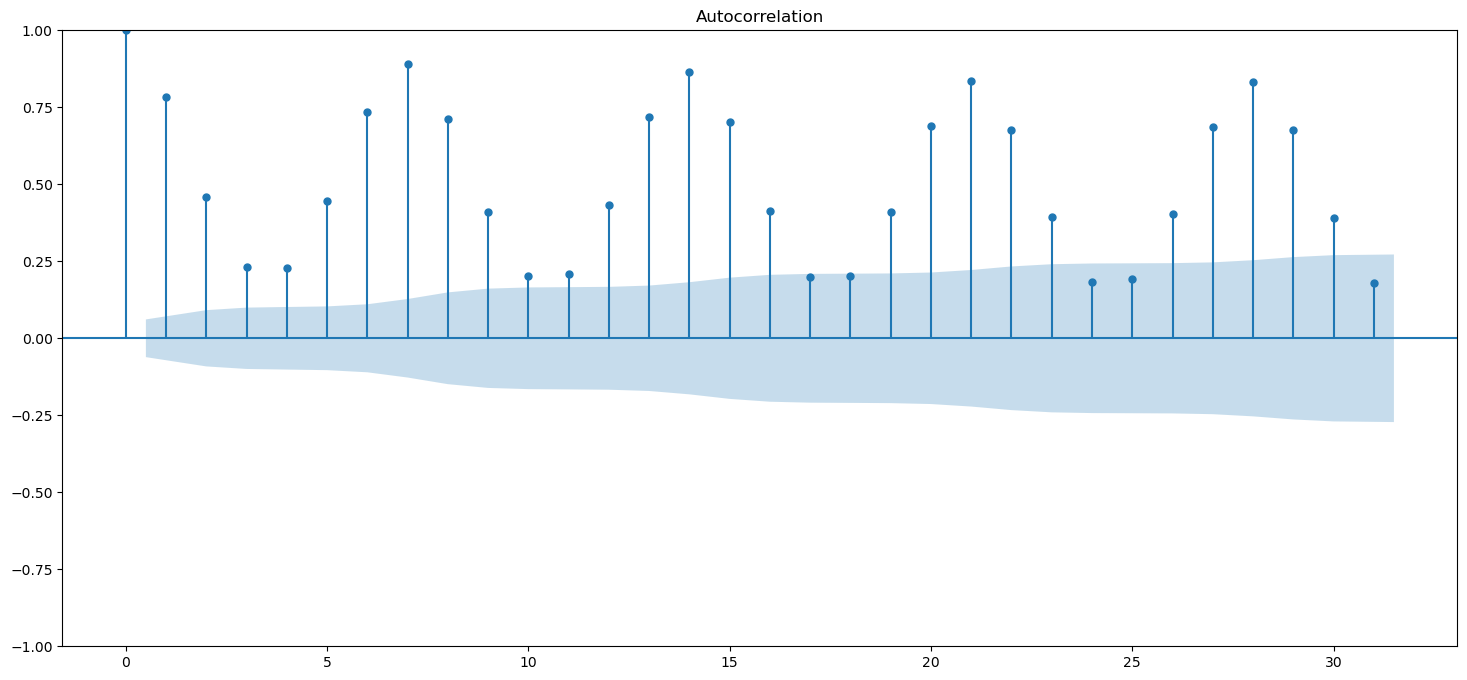

In [256]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

result = adfuller(data["amount"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

plot_acf(data)
plt.show()

In [257]:
##PARTIAL AUTOCORRELATION##
##CORRELATION IN SALES AT TIME K AND K-NLAGS BACKWARDS
##EVEN LAG 14 SEEMS TO EXPLAIN TODAY'S AMOUNT (ELEKTRA CASE).
from statsmodels.graphics.tsaplots import plot_pacf

In [258]:
##ARIMA PARAMETER SEARCH##

In [259]:
##SPLIT THE DATABASE INTO TRAIN AND TEST (WITH THE DATABASE SORTED TEMPORALLY)##

In [260]:
traindata = data[0:981] #data[0:800]
traindata.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07'],
              dtype='datetime64[ns]', name='date', length=981, freq=None)

In [261]:
testdata = data[981:1025] #data[801:1025]
testdata.index

DatetimeIndex(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
               '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09',
               '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
               '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17',
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [262]:
traindata.shape, testdata.shape

((981, 1), (44, 1))

In [263]:
##WE INSTALL A TIME SERIES LIBRARY THAT HELPS US TO SELECT THE BEST ARIMA MODEL AUTOMATICALLY##
!pip install pmdarima


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [264]:
##WE APPLY THE AUTOARIMA MODULE THAT SELECTS THE BEST MODEL FROM AMONG SEVERAL CANDIDATES
## BASED ON THE AUTOCORRELATION GRAPH, WE OBSERVE THAT VALUES OF UP TO 14 LAGS CAN AFFECT TODAY'S AMOUNT. WHICH IMPLIES P AND Q MAX=14 (ALWAYS TAKE CARE OF MODEL PARSIMONY).

In [265]:
# Import the library, require install and restart, uncomment to use
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function  dataset 
# Adjusts the best arima model by looking for the one that minimizes the Akaike criterion (AIC)
stepwise_fit = auto_arima(traindata['amount'], start_p = 1, start_q = 1, 
                          max_p = 14, max_q = 14, m = 7 , 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
#p:The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values.
#d:The degree of differencing.
#q:The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=29081.387, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=29631.100, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=29219.431, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=29144.287, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=29632.307, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=29332.789, Time=0.14 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=29059.153, Time=0.77 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=29220.528, Time=0.57 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=29057.679, Time=1.86 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=29153.874, Time=1.07 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=29057.684, Time=3.38 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=29056.049, Time=2.04 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=29054.099, Time=1.26 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=29125.784, Time=0.87 sec
 ARIMA(1,0,0)(0,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  981
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -14521.005
Date:                                Mon, 05 Feb 2024   AIC                          29054.010
Time:                                        18:05:31   BIC                          29083.298
Sample:                                    12-31-2020   HQIC                         29065.155
                                         - 09-07-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.53e+04   6361.239      3.977      0.000    1.28e+04    3.78e+04
ar.L1          0.5431      0.017     32.794      0.000       0.511       0.576
ar.L2         -0.0145      0.027     -0.536      0.592      -0.068       0.039
ma.S.L7       -0.6238      0.021    -30.027      0.000      -0.665      -0.583
ma.S.L14      -0.2118      0.033     -6.429      0.000      -0.276      -0.147
sigma2      6.897e+11   8.44e-05   8.17e+15      0.000     6.9e+11     6.9e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             14639.01
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               4.95   Skew:                            -1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.96e+32. Standard errors may be unstable.
"""

In [266]:
##IGNORE THIS CELL FOR NOW
# Manual grid search
import itertools
q = d = range(0, 2)
p=range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


In [267]:
##WE ASSIGN A TIME INDEX 
traindata.index = pd.DatetimeIndex(traindata.index.values,
                               freq=traindata.index.inferred_freq)

In [268]:
##WE ESTIMATE THE BEST MODEL SUGGESTED BY AUTO_ARIMA WITH THE SARIMAX MODULE (P=4,I=0,Q=0) (p=2,i=1,q=2,7-seven to indicate weekly seasonality-)
## FURTHERMORE, ADDITIONAL ESTIMATION CONTROLS ARE PRESENTED.
mod = sm.tsa.statespace.SARIMAX(traindata['amount'],  
                order = (2, 0, 0),  
                seasonal_order =(0, 1, 2, 7))  

results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48141D+01    |proj g|=  2.45311D-02


 This problem is unconstrained.



At iterate    5    f=  1.48106D+01    |proj g|=  6.42912D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     10      1     0     0   5.715D-06   1.481D+01
  F =   14.810558997461671     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5605      0.015     38.044      0.000       0.532       0.589
ar.L2          0.0095      0.023      0.406      0.685      -0.036       0.055
ma.S.L7       -0.5965      0.022    -27.070  

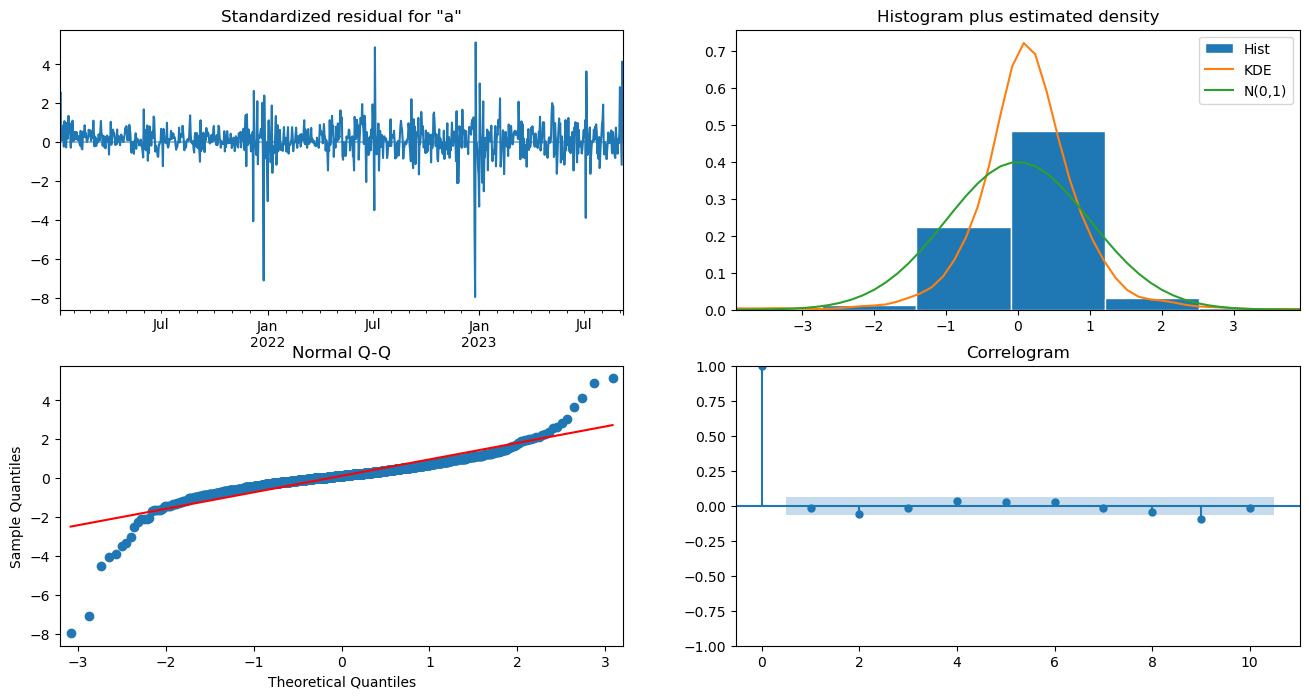

In [269]:
###NOTE THAT THERE ARE SOME DAYS WITH STRONG DEVIATIONS (DEC. 25, JAN. 1)
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [270]:
##WE NOW GENERATE THE FORECAST WITH THE ESTIMATED MODEL WITH THE TEST DATASET
pred = results.get_prediction(start=pd.to_datetime('2023-09-08'),end=pd.to_datetime('2023-09-30'), dynamic=False)
pred_test = pred.conf_int()
res = pred.predicted_mean
pred_test["result"] = pred.predicted_mean
pred_test["y"] = testdata
print("pred_test:\n", pred_test)

pred_test:
             lower amount  upper amount        result            y
2023-09-08  1.027107e+07  1.352792e+07  1.189950e+07  12387078.39
2023-09-09  1.092658e+07  1.466019e+07  1.279339e+07  13750238.46
2023-09-10  9.523994e+06  1.340361e+07  1.146380e+07  12572008.55
2023-09-11  6.387640e+06  1.031466e+07  8.351150e+06   8069372.31
2023-09-12  5.777107e+06  9.719785e+06  7.748446e+06   6250790.48
2023-09-13  4.823648e+06  8.771525e+06  6.797586e+06   5772592.34
2023-09-14  5.397778e+06  9.347385e+06  7.372582e+06   6170513.15
2023-09-15  8.855150e+06  1.303939e+07  1.094727e+07   9829235.12
2023-09-16  9.891306e+06  1.414680e+07  1.201906e+07  11123317.16
2023-09-17  8.895020e+06  1.317402e+07  1.103452e+07  11274156.68
2023-09-18  6.143411e+06  1.043020e+07  8.286807e+06   8509119.31
2023-09-19  4.905033e+06  9.194418e+06  7.049725e+06   6343863.76
2023-09-20  4.232670e+06  8.522918e+06  6.377794e+06   5839099.60
2023-09-21  4.936921e+06  9.227457e+06  7.082189e+06   6300566.1

In [271]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test["ae"] = abs(pred_test["y"]-pred_test["result"])
mae = pred_test["ae"].mean() 
print("mae:", mae)
mse = ((pred_test["y"]-pred_test["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test["pe"] = abs((pred_test["y"]-pred_test["result"]) / pred_test["y"])
mape = pred_test["pe"].mean() 
print("mape:", mape)

wape = sum(pred_test['ae']) / sum((pred_test["y"]))
print("wape:", wape)

mae: 749943.5724786374
rmse: 845841.1036632853
mape: 0.08992066901740699
wape: 0.08210575583690363


In [272]:
##MAPE=8.9% CON MODELO BASE SIN EXÓGENAS ##

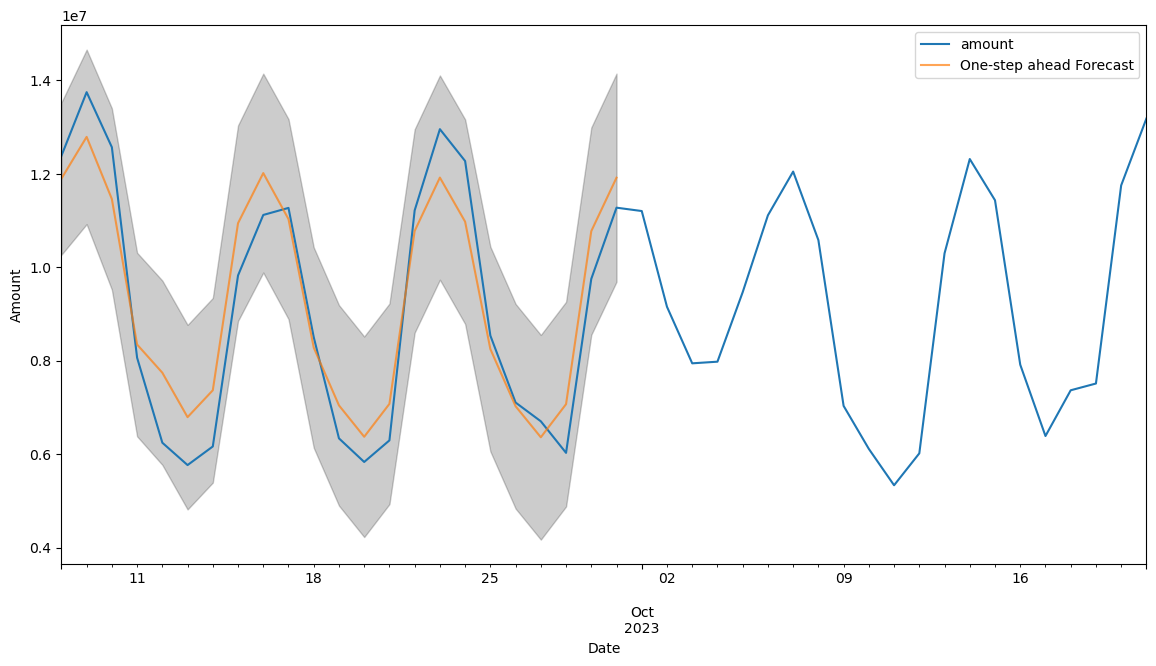

In [273]:
###GENERATE THE CONFIDENCE BANDS OF THE ESTIMATES (LOWER AND UPPER LIMIT) AND PLOT THE PREDICTED VALUE VS. THE ACTUAL VALUE

pred_ci = pred.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred.predicted_mean

ax = testdata.plot(label='observed')
#ax = traindata.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [274]:
##WE NOW INCORPORATE THE EXCHANGE RATE LAGS AS PREDICTORS OF THE EXCHANGE RATE##

In [275]:
##TIME SERIES FORMAT
data2 = df_pilot
data2.dtypes #day object
data2['date'] = pd.DatetimeIndex(data2['date'])
df_pilot.dtypes   #Month datetime64[ns]

data2.index  #RangeIndex()
data2 = data2.set_index('date')

In [276]:
##WE ELIMINATE STRING VARIABLES##
data2=data2.loc[:,['amount', 'feed_price_retardo_1', 'feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']]

In [277]:
data2 = data2.sort_values(by='date')

In [278]:
##SARIMAX PARAMETER SEARCH##

In [279]:
traindata2 = data2[0:981] #data[0:800]
traindata2=traindata2.loc[:,['amount', 'feed_price_retardo_1', 'feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']]
traindata2.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07'],
              dtype='datetime64[ns]', name='date', length=981, freq=None)

In [280]:
testdata2 = data2[981:1025] #data[801:1025]
testdata2=testdata2.loc[:,['amount', 'feed_price_retardo_1','feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']]
testdata2.index


DatetimeIndex(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
               '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09',
               '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
               '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17',
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [281]:
traindata2.shape, testdata2.shape

((981, 8), (44, 8))

In [282]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

traindata2=traindata2.fillna(method='bfill')
testdata2=testdata2.fillna(method='bfill')
traindata2=traindata2.fillna(method='ffill')
testdata2=testdata2.fillna(method='ffill')
exog=['feed_price_retardo_1','feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']
mod = sm.tsa.SARIMAX(traindata2[['amount']], order=(2,0,0), seasonal_order =(0, 1, 2, 7), exog=traindata2[exog])
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  981
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -14505.676
Date:                                Mon, 05 Feb 2024   AIC                          29035.351
Time:                                        18:05:36   BIC                          29093.928
Sample:                                    12-31-2020   HQIC                         29057.643
                                         - 09-07-2023                                         
Covariance Type:                                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
feed_price_retardo_1  1.256e+06   2.89e+05      4.353      0.0

In [283]:
testdata2.tail()

,amount,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,
2023-10-17,6394084.62,17.9119,18.0448,18.0913,18.0913,17.9574,17.8337,17.9358
2023-10-18,7372639.68,18.0094,17.9119,18.0448,18.0913,18.0913,17.9574,17.8337
2023-10-19,7517141.00,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913,17.9574
2023-10-20,11755749.86,18.3207,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913
2023-10-21,13185622.15,18.3207,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913


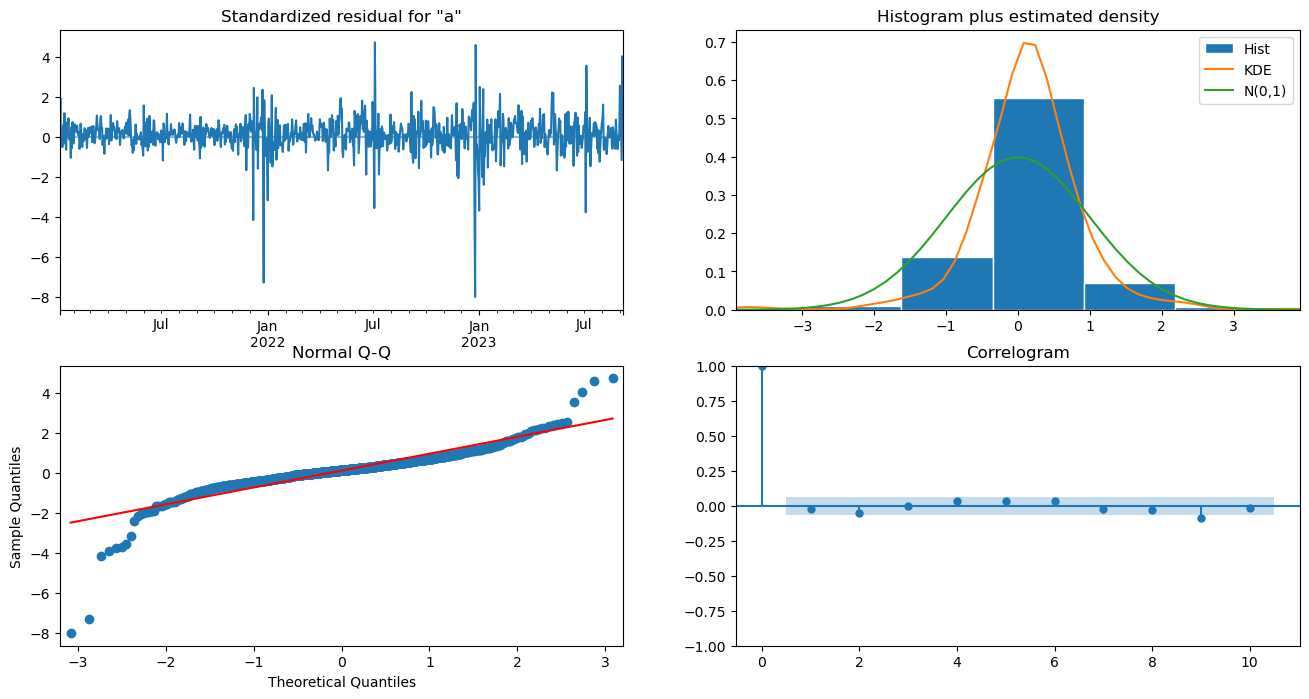

In [284]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()

In [285]:
testdata2=testdata2[0:20]
pred2 = res.get_prediction(start=pd.to_datetime('2023-09-08'),end=pd.to_datetime('2023-09-27'), dynamic=False, exog=testdata2[exog])
pred_test2 = pred2.conf_int()
res2 = pred2.predicted_mean
pred_test2["result"] = pred2.predicted_mean
pred_test2["y"] = testdata2['amount']
print("pred_test2:\n", pred_test2)

pred_test2:
             lower amount  upper amount        result            y
2023-09-08  1.029597e+07  1.348039e+07  1.188818e+07  12387078.39
2023-09-09  1.105664e+07  1.458909e+07  1.282286e+07  13750238.46
2023-09-10  9.646968e+06  1.324987e+07  1.144842e+07  12572008.55
2023-09-11  6.396394e+06  1.001424e+07  8.205315e+06   8069372.31
2023-09-12  5.485479e+06  9.106518e+06  7.295998e+06   6250790.48
2023-09-13  4.379040e+06  8.000765e+06  6.189902e+06   5772592.34
2023-09-14  4.837635e+06  8.459506e+06  6.648570e+06   6170513.15
2023-09-15  8.351877e+06  1.220684e+07  1.027936e+07   9829235.12
2023-09-16  9.659303e+06  1.356599e+07  1.161265e+07  11123317.16
2023-09-17  8.870542e+06  1.278826e+07  1.082940e+07  11274156.68
2023-09-18  6.163459e+06  1.008354e+07  8.123502e+06   8509119.31
2023-09-19  5.160060e+06  9.080651e+06  7.120355e+06   6343863.76
2023-09-20  4.350664e+06  8.271364e+06  6.311014e+06   5839099.60
2023-09-21  5.069877e+06  8.990601e+06  7.030239e+06   6300566.

In [286]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test2["ae"] = abs(pred_test2["y"]-pred_test2["result"])
mae = pred_test2["ae"].mean() 
print("mae:", mae)
mse = ((pred_test2["y"]-pred_test2["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test2["pe"] = abs((pred_test2["y"]-pred_test2["result"]) / pred_test2["y"])
mape = pred_test2["pe"].mean() 
print("mape:", mape)

wape = sum(pred_test2['ae']) / sum((pred_test2["y"]))
print("wape:", wape)

mae: 573148.4825095066
rmse: 656173.7043130737
mape: 0.06518756674788359
wape: 0.06263569087818502


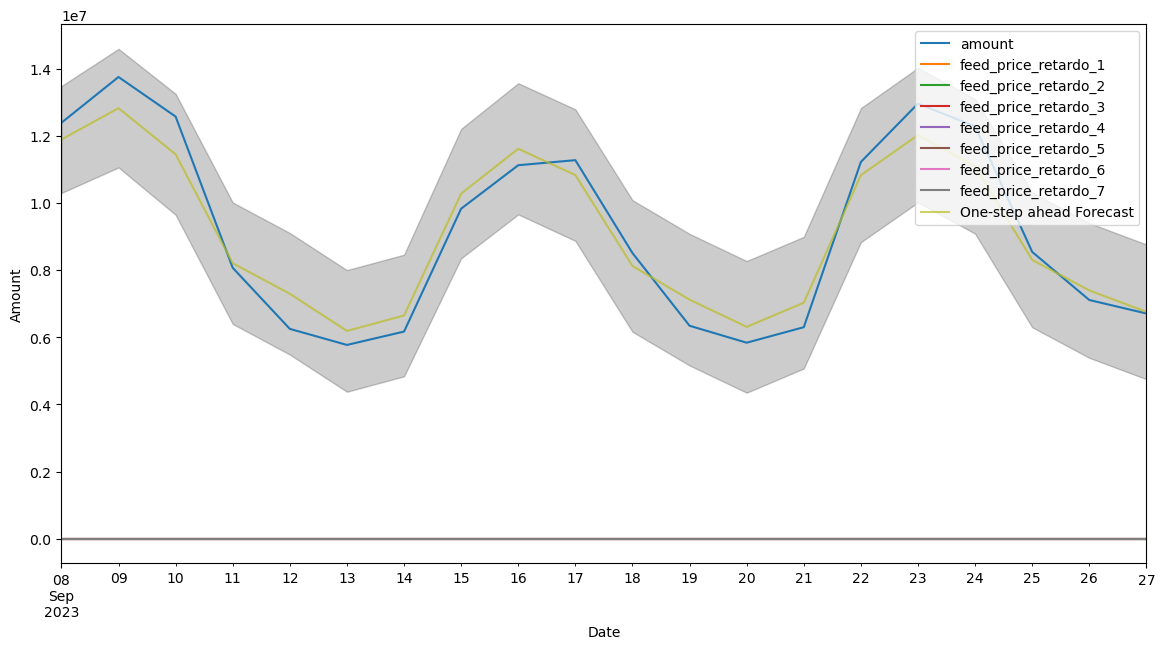

In [287]:
pred_ci2 = pred2.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred2.predicted_mean

ax = testdata2.plot(label='observed')
#ax = traindata.plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [288]:
##SAME APPROACH BUT WORKING WITH DAILY EXCHANGE RATE DIFFERENCES

In [289]:
data3=data2.copy()

In [290]:
data3=data3.fillna(method='bfill')
data3=data3.fillna(method='ffill')

In [291]:
data3['var_rate_lag1']=data3.feed_price_retardo_1-data3.feed_price_retardo_2
data3['var_rate_lag2']=data3.feed_price_retardo_2-data3.feed_price_retardo_3
data3['var_rate_lag3']=data3.feed_price_retardo_3-data3.feed_price_retardo_4
data3['var_rate_lag4']=data3.feed_price_retardo_4-data3.feed_price_retardo_5
data3['var_rate_lag5']=data3.feed_price_retardo_5-data3.feed_price_retardo_6
data3['var_rate_lag6']=data3.feed_price_retardo_6-data3.feed_price_retardo_7
data3.tail(2)

,amount,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,,,,,,,,
2023-10-20,11755749.86,18.3207,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913,0.0481,0.2632,0.0975,-0.1329,-0.0465,0.0
2023-10-21,13185622.15,18.3207,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913,0.0481,0.2632,0.0975,-0.1329,-0.0465,0.0


In [292]:
##WE ELIMINATE SOME VARIABLES##
data3=data3.loc[:,['amount', 'var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6']]
data3.tail()

,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,
2023-10-17,6394084.62,-0.1329,-0.0465,0.0000,0.1339,0.1237,-0.1021
2023-10-18,7372639.68,0.0975,-0.1329,-0.0465,0.0000,0.1339,0.1237
2023-10-19,7517141.00,0.2632,0.0975,-0.1329,-0.0465,0.0000,0.1339
2023-10-20,11755749.86,0.0481,0.2632,0.0975,-0.1329,-0.0465,0.0000
2023-10-21,13185622.15,0.0481,0.2632,0.0975,-0.1329,-0.0465,0.0000


In [293]:
##SARIMAX PARAMETER SEARCH##

In [294]:
traindata3 = data3[0:981] #data[0:800]
traindata3.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07'],
              dtype='datetime64[ns]', name='date', length=981, freq=None)

In [295]:
testdata3 = data3[981:1025] #data[801:1025]
testdata3.index

DatetimeIndex(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
               '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09',
               '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
               '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17',
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [296]:
traindata3.shape, testdata3.shape

((981, 7), (44, 7))

In [297]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog3=['var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6']
mod2 = sm.tsa.SARIMAX(traindata3[['amount']], order=(2,0,0), seasonal_order =(0, 1, 2, 7), exog=traindata3[exog3])
res2 = mod2.fit(maxiter=1000, disp=False)
print(res2.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  981
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -14510.322
Date:                                Mon, 05 Feb 2024   AIC                          29042.644
Time:                                        18:05:39   BIC                          29096.339
Sample:                                    12-31-2020   HQIC                         29063.078
                                         - 09-07-2023                                         
Covariance Type:                                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
var_rate_lag1  1.192e+06    2.8e+05      4.251      0.000    6.43e+05    1.7

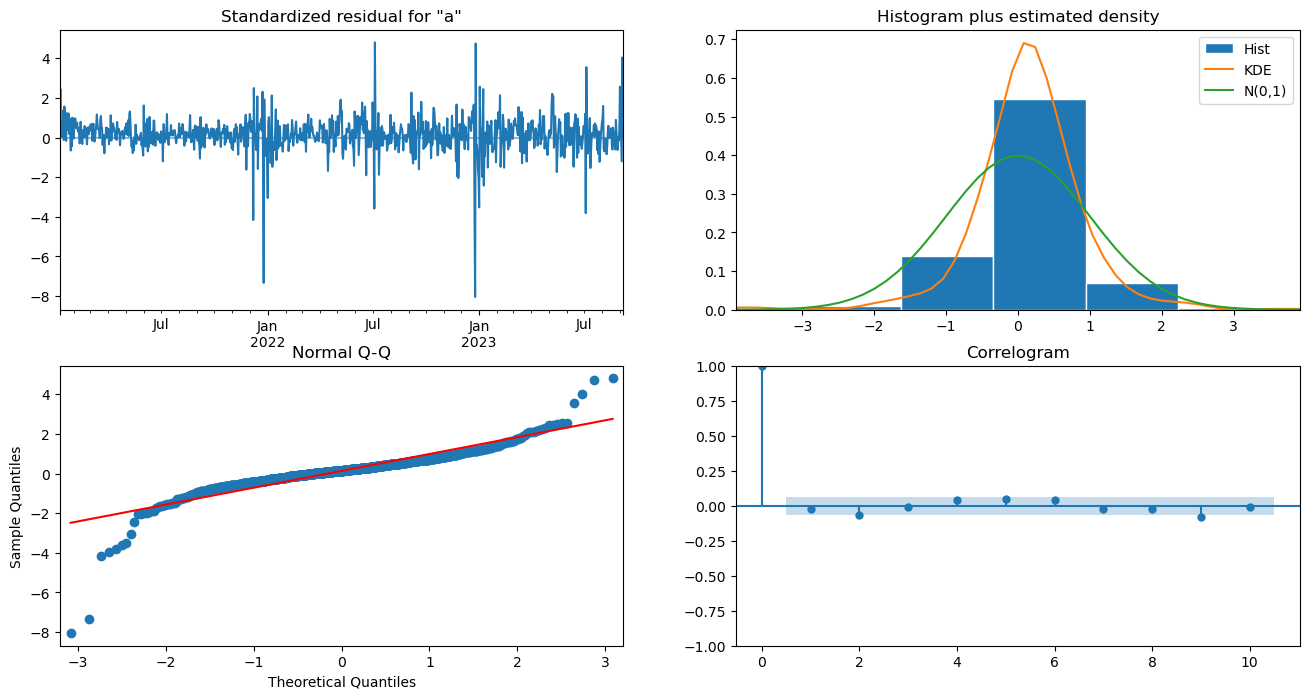

In [298]:
res2.plot_diagnostics(figsize=(16, 8))
plt.show()

In [299]:
testdata3=testdata3[0:20]
pred3 = res2.get_prediction(start=pd.to_datetime('2023-09-08'),end=pd.to_datetime('2023-09-27'), dynamic=False, exog=testdata3[exog3])
pred_test3 = pred3.conf_int()
res2 = pred3.predicted_mean
pred_test3["result"] = pred3.predicted_mean
pred_test3["y"] = testdata3['amount']
print("pred_test2:\n", pred_test3)

pred_test2:
             lower amount  upper amount        result            y
2023-09-08  1.033888e+07  1.351944e+07  1.192916e+07  12387078.39
2023-09-09  1.108319e+07  1.462531e+07  1.285425e+07  13750238.46
2023-09-10  9.638715e+06  1.327095e+07  1.145483e+07  12572008.55
2023-09-11  6.349835e+06  1.000555e+07  8.177693e+06   8069372.31
2023-09-12  5.475303e+06  9.137211e+06  7.306257e+06   6250790.48
2023-09-13  4.345312e+06  8.008857e+06  6.177085e+06   5772592.34
2023-09-14  4.807448e+06  8.471427e+06  6.639437e+06   6170513.15
2023-09-15  8.315645e+06  1.222719e+07  1.027142e+07   9829235.12
2023-09-16  9.610783e+06  1.357963e+07  1.159521e+07  11123317.16
2023-09-17  8.813403e+06  1.279735e+07  1.080538e+07  11274156.68
2023-09-18  6.117873e+06  1.010581e+07  8.111842e+06   8509119.31
2023-09-19  5.112846e+06  9.101839e+06  7.107342e+06   6343863.76
2023-09-20  4.313469e+06  8.302740e+06  6.308104e+06   5839099.60
2023-09-21  5.036903e+06  9.026249e+06  7.031576e+06   6300566.

In [300]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test3["ae"] = abs(pred_test3["y"]-pred_test3["result"])
mae = pred_test3["ae"].mean() 
print("mae:", mae)
mse = ((pred_test3["y"]-pred_test3["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test3["pe"] = abs((pred_test3["y"]-pred_test3["result"]) / pred_test3["y"])
mape = pred_test3["pe"].mean() 
print("mape:", mape)
wape = sum(pred_test3['ae']) / sum((pred_test3["y"]))
print("wape:", wape)

mae: 565433.2060945273
rmse: 651919.4399733549
mape: 0.06426140781606188
wape: 0.061792538216500374


In [301]:
##MAPE BAJA DESDE 8.99% A 6.42 % CON REZAGOS DE VARIACIONES DEL TIPO DE CAMBIO#
## Y TENER EN CUENTA QUE AÚN NO ENCONTRAMOS LA FORMA DE ENTRENAR CON EXÓGENAS CON AUTOARIMA
## VAMOS A ESTUDIAR LA LIBRERIA SKFORECAST QUE SUPUESTAMENTE PERMITE ENCONTRAR EL MEJOR MODELO CON AUTOARIMA Y EXOGENAS

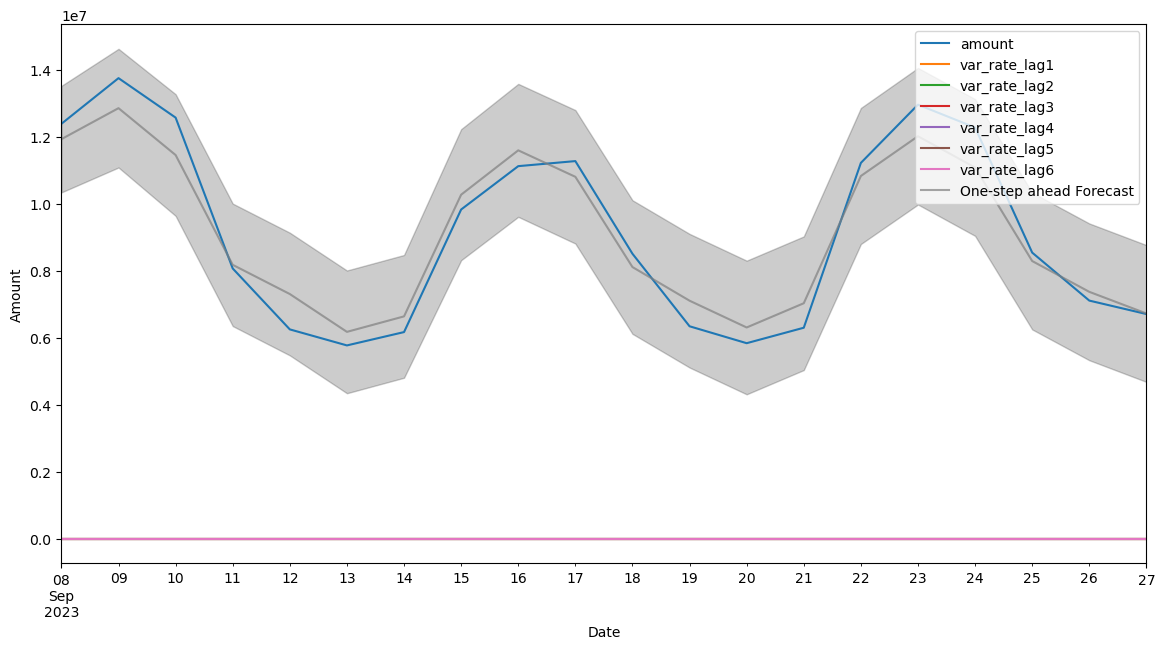

In [302]:
pred_ci3 = pred3.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred3.predicted_mean

ax = testdata3.plot(label='observed')
#ax = traindata.plot(label='observed')
pred3.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [303]:
###NOW WE TEST CANCELLATIONS###

In [304]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'viamericas'
database_name2= 'analytics'
table1_name = 'forex_feed_market'
table2_name = 'daily_sales_count_cancelled_v2'##WE LOAD THE BASE WITH CANCELLATIONS

In [305]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
#df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table1_name};', conn)
df3 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name2}.{table2_name};', conn)

In [306]:
df3.shape

(101970, 5)

In [307]:
##WE NEED TO GO ONE STEP BACK, AND BEFORE GROUPING THE AMOUNT BY COUNTRY DATE AND PAYER, COUNT THE CANCELLATIONS (GENERATE THE TABLE IN ATHENA)

In [308]:
df3.head()

,payer,country,date,amount,tx_cancelled
0,BBVA - BANCOMER (BTS),MEXICO,2022-04-09,721684.70,64
1,INTERMEX,MEXICO,2022-04-09,312692.44,47
2,ECUAGIROS,ECUADOR,2022-05-13,51985.54,20
3,TELEDOLAR,COSTA RICA,2022-04-12,57395.00,12
4,ARGENPER,ARGENTINA,2022-04-12,1093.00,0


In [309]:
##FILTERING MEXICO##

In [310]:
df_montos_mex2=df3.loc[df3.country=='MEXICO']

In [311]:
df_montos_mex2.amount.sum()

13655009099.176899

In [312]:
##AS PART OF A PILOT TEST WE WILL ONLY WORK WITH ONE PAYER, AND THEN WE WILL GENERALIZE THE ROUTINE##
## WE WILL NOW FIT A MODEL WITH LAGS OF THE CANCELLATIONS (SARIMAX) TO SEE IF IT PERFORMS BETTER THAN THE SIMPLE ARIMA MODEL.
##WE START WITH ELEKTRA AND THE CASE WITHOUT EXOGENOUS VARIABLES ##
df_pilot4=df_montos_mex2.loc[df_montos_mex2.payer=='ELEKTRA (MEXICO)']
df_pilot4.shape

(1025, 5)

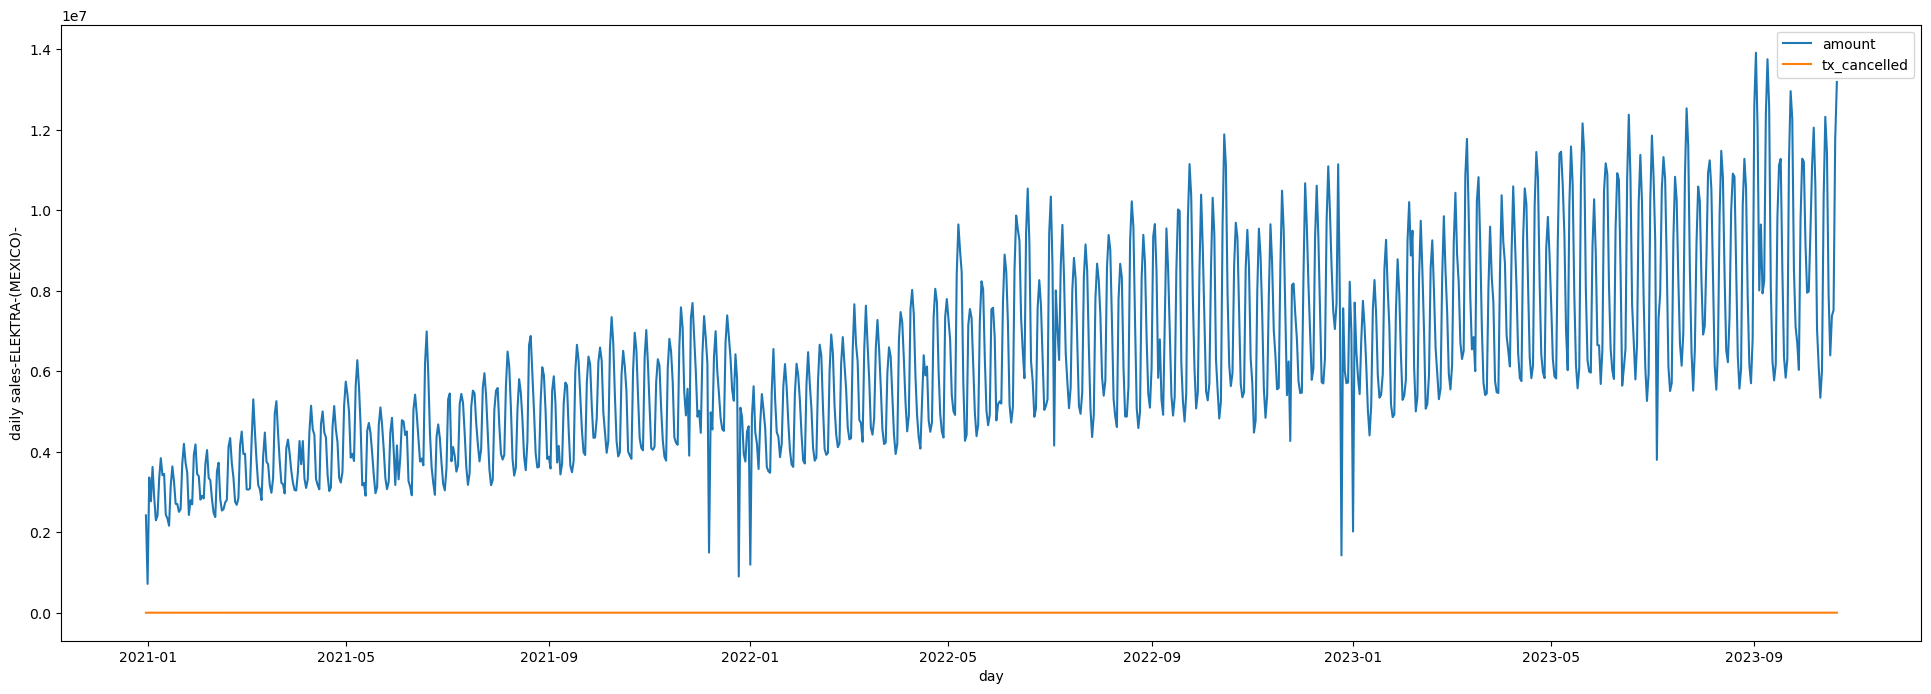

In [313]:
ax = df_pilot4.set_index('date').plot(figsize=(24, 8))
ax.set_ylabel('daily sales-ELEKTRA-(MEXICO)-')
ax.set_xlabel('day')
plt.show()

In [314]:
##TIME SERIES FORMAT
data = df_pilot4
data.dtypes #day object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot.dtypes   # datetime64[ns]

data.index  #RangeIndex()
data = data.set_index('date')

In [315]:
data = data.sort_values(by='date')
data.head()

,payer,country,amount,tx_cancelled
date,,,,
2020-12-31,ELEKTRA (MEXICO),MEXICO,2418346.71,278
2021-01-01,ELEKTRA (MEXICO),MEXICO,717241.42,94
2021-01-02,ELEKTRA (MEXICO),MEXICO,3360407.85,358
2021-01-03,ELEKTRA (MEXICO),MEXICO,2767481.77,278
2021-01-04,ELEKTRA (MEXICO),MEXICO,3621953.17,323


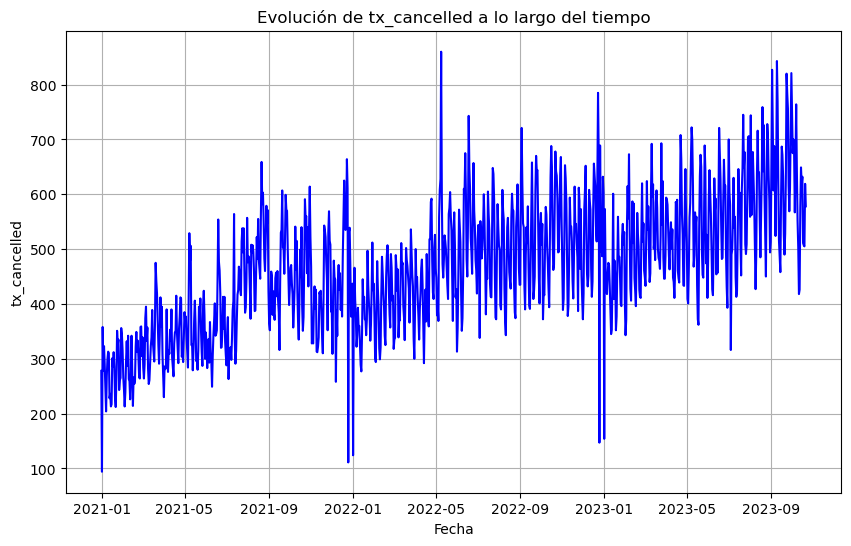

In [316]:

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['tx_cancelled'], linestyle='-', color='b')

plt.title('Evolución de tx_cancelled a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('tx_cancelled')
plt.grid(True)
plt.show()

In [317]:
for i in range(1, 8):
        nombre_columna = f'tx_cancelled_{i}'
        data[nombre_columna] = data['tx_cancelled'].shift(i)

In [318]:
##WE ELIMINATE STRING VARIABLES AND OTHER VARIABLES##
##WE ELIMINATE STRING VARIABLES##
data=data.loc[:,['amount', 'tx_cancelled_1', 'tx_cancelled_2', 'tx_cancelled_3', 'tx_cancelled_4', 'tx_cancelled_5', 'tx_cancelled_6', 'tx_cancelled_7']]

In [319]:
data.head()

,amount,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7
date,,,,,,,,
2020-12-31,2418346.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,717241.42,278.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,3360407.85,94.0,278.0,NaN,NaN,NaN,NaN,NaN
2021-01-03,2767481.77,358.0,94.0,278.0,NaN,NaN,NaN,NaN
2021-01-04,3621953.17,278.0,358.0,94.0,278.0,NaN,NaN,NaN


In [320]:
data=data.fillna(method='bfill')
data=data.fillna(method='ffill')
data.head()

,amount,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7
date,,,,,,,,
2020-12-31,2418346.71,278.0,278.0,278.0,278.0,278.0,278.0,278.0
2021-01-01,717241.42,278.0,278.0,278.0,278.0,278.0,278.0,278.0
2021-01-02,3360407.85,94.0,278.0,278.0,278.0,278.0,278.0,278.0
2021-01-03,2767481.77,358.0,94.0,278.0,278.0,278.0,278.0,278.0
2021-01-04,3621953.17,278.0,358.0,94.0,278.0,278.0,278.0,278.0


In [321]:
##WE DECOMPOSE THE SERIES INTO TREND, SEASONALITY AND RESIDUALS

In [322]:
data = data.sort_values(by='date')
data.head()

,amount,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7
date,,,,,,,,
2020-12-31,2418346.71,278.0,278.0,278.0,278.0,278.0,278.0,278.0
2021-01-01,717241.42,278.0,278.0,278.0,278.0,278.0,278.0,278.0
2021-01-02,3360407.85,94.0,278.0,278.0,278.0,278.0,278.0,278.0
2021-01-03,2767481.77,358.0,94.0,278.0,278.0,278.0,278.0,278.0
2021-01-04,3621953.17,278.0,358.0,94.0,278.0,278.0,278.0,278.0


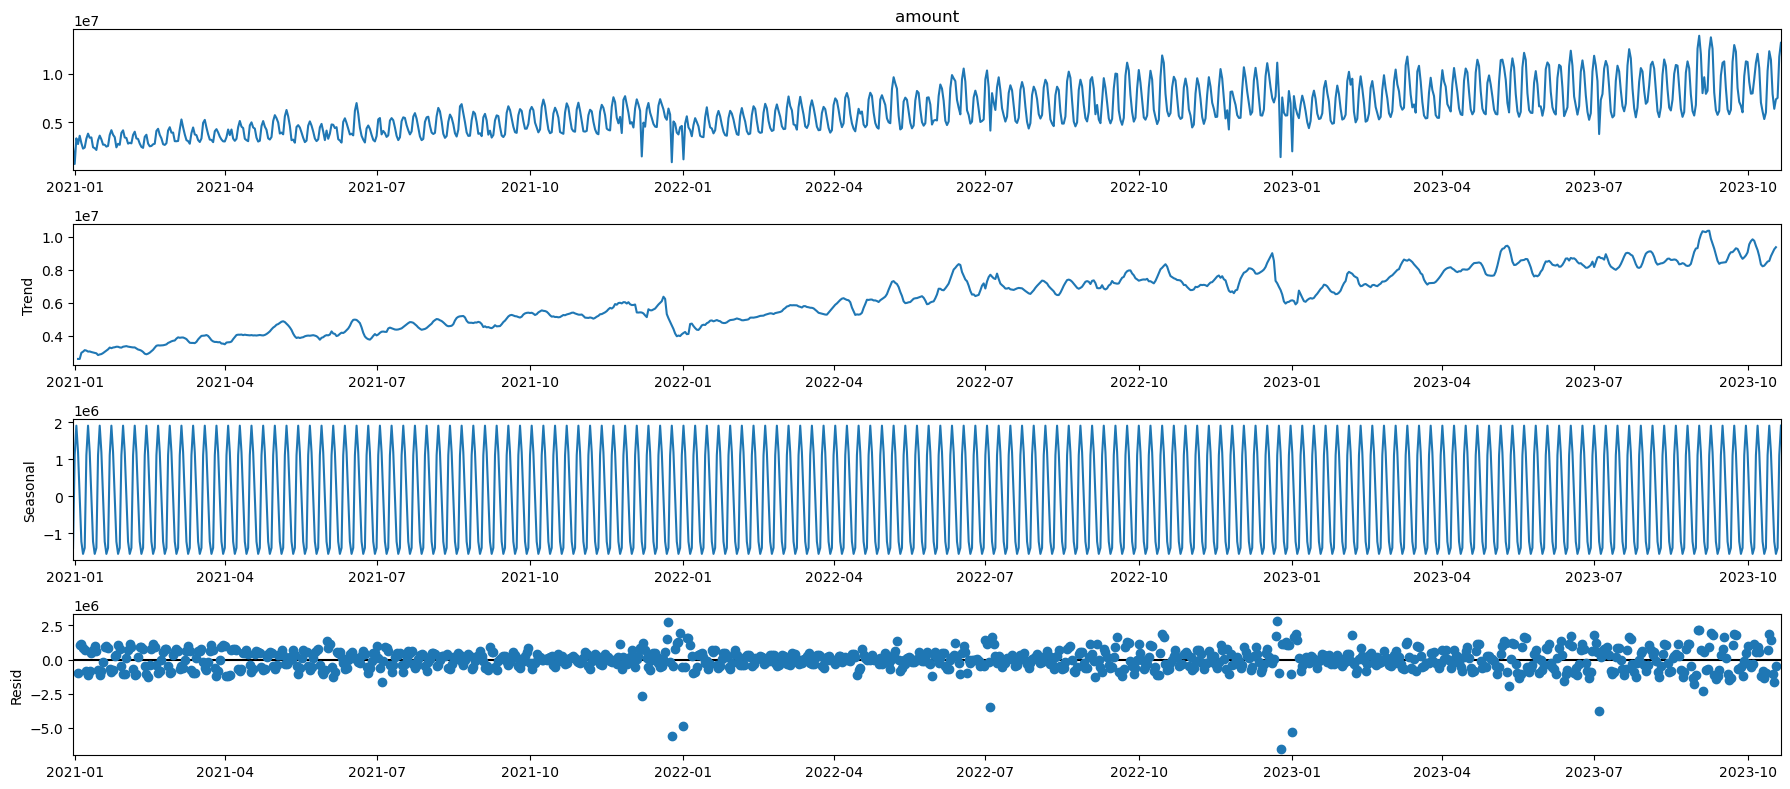

In [323]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data['amount'], model='additive', period=None) #multiplicative, additive
fig = decomposition.plot()
plt.show()

In [324]:
data['var_tx_cancelled_1']=data.tx_cancelled_1-data.tx_cancelled_2
data['var_tx_cancelled_2']=data.tx_cancelled_2-data.tx_cancelled_3
data['var_tx_cancelled_3']=data.tx_cancelled_3-data.tx_cancelled_4
data['var_tx_cancelled_4']=data.tx_cancelled_4-data.tx_cancelled_5
data['var_tx_cancelled_5']=data.tx_cancelled_5-data.tx_cancelled_6
data['var_tx_cancelled_6']=data.tx_cancelled_6-data.tx_cancelled_7
data.tail()

,amount,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
date,,,,,,,,,,,,,,
2023-10-17,6394084.62,632.0,618.0,649.0,577.0,426.0,418.0,503.0,14.0,-31.0,72.0,151.0,8.0,-85.0
2023-10-18,7372639.68,511.0,632.0,618.0,649.0,577.0,426.0,418.0,-121.0,14.0,-31.0,72.0,151.0,8.0
2023-10-19,7517141.00,507.0,511.0,632.0,618.0,649.0,577.0,426.0,-4.0,-121.0,14.0,-31.0,72.0,151.0
2023-10-20,11755749.86,505.0,507.0,511.0,632.0,618.0,649.0,577.0,-2.0,-4.0,-121.0,14.0,-31.0,72.0
2023-10-21,13185622.15,619.0,505.0,507.0,511.0,632.0,618.0,649.0,114.0,-2.0,-4.0,-121.0,14.0,-31.0


In [325]:
##WE ELIMINATE SOME VARIABLES##
data=data.loc[:,['amount', 'var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6']]
data.tail()

,amount,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
date,,,,,,,
2023-10-17,6394084.62,14.0,-31.0,72.0,151.0,8.0,-85.0
2023-10-18,7372639.68,-121.0,14.0,-31.0,72.0,151.0,8.0
2023-10-19,7517141.00,-4.0,-121.0,14.0,-31.0,72.0,151.0
2023-10-20,11755749.86,-2.0,-4.0,-121.0,14.0,-31.0,72.0
2023-10-21,13185622.15,114.0,-2.0,-4.0,-121.0,14.0,-31.0


In [326]:
##SARIMAX PARAMETER SEARCH##

In [327]:
traindata3 = data[0:981] #data[0:800]
traindata3.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07'],
              dtype='datetime64[ns]', name='date', length=981, freq=None)

In [328]:
testdata3 = data[981:1025] #data[0:1025]
testdata3.index

DatetimeIndex(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
               '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09',
               '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
               '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17',
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [329]:
traindata3.shape, testdata3.shape

((981, 7), (44, 7))

In [330]:
traindata3

,amount,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
date,,,,,,,
2020-12-31,2418346.71,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01,717241.42,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02,3360407.85,-184.0,0.0,0.0,0.0,0.0,0.0
2021-01-03,2767481.77,264.0,-184.0,0.0,0.0,0.0,0.0
2021-01-04,3621953.17,-80.0,264.0,-184.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2023-09-03,12018433.11,172.0,142.0,19.0,-93.0,-46.0,-70.0
2023-09-04,8006036.40,-108.0,172.0,142.0,19.0,-93.0,-46.0
2023-09-05,9644820.20,-112.0,-108.0,172.0,142.0,19.0,-93.0


In [331]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog3=['var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6']
mod2 = sm.tsa.SARIMAX(traindata3[['amount']], order=(2,0,0), seasonal_order =(0, 1, 2, 7), exog=traindata3[exog3])
res2 = mod2.fit(maxiter=1000, disp=False)
print(res2.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  981
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -14571.493
Date:                                Mon, 05 Feb 2024   AIC                          29164.986
Time:                                        18:06:05   BIC                          29218.682
Sample:                                    12-31-2020   HQIC                         29185.420
                                         - 09-07-2023                                         
Covariance Type:                                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
var_tx_cancelled_1  3333.0577    524.412      6.356      0.000    

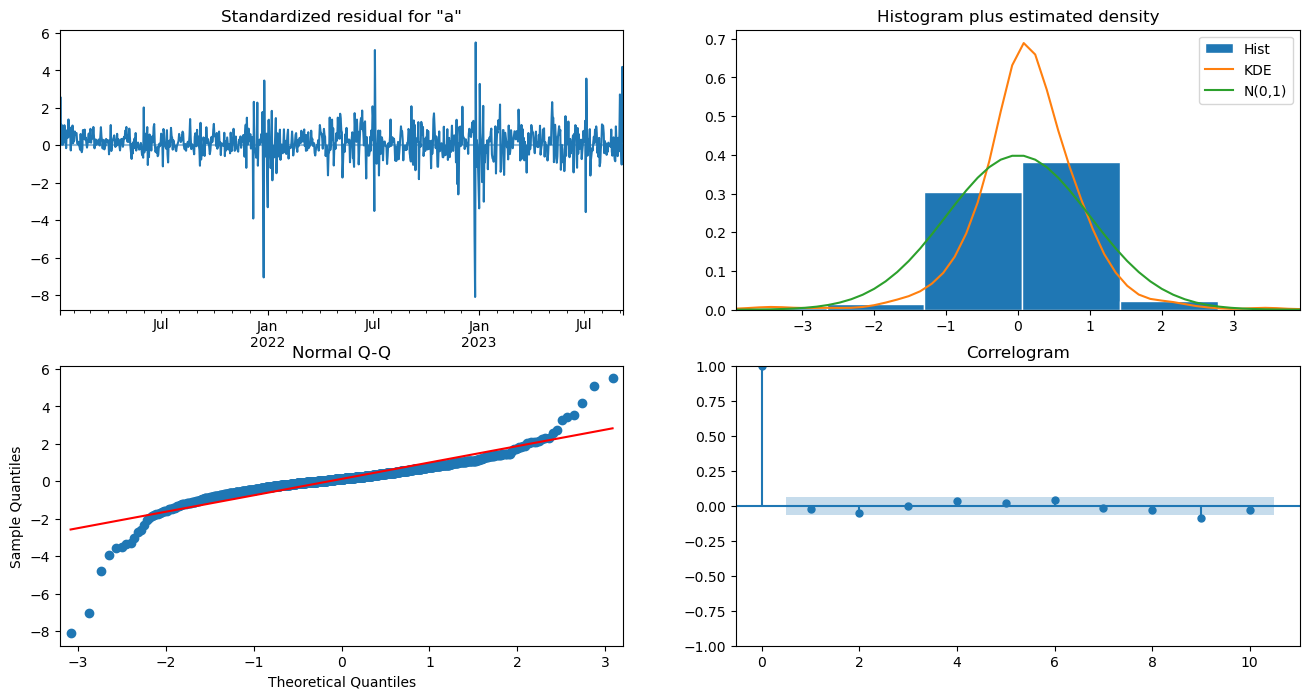

In [332]:
res2.plot_diagnostics(figsize=(16, 8))
plt.show()

In [333]:
testdata3=testdata3[0:20]
pred3 = res2.get_prediction(start=pd.to_datetime('2023-09-08'),end=pd.to_datetime('2023-09-27'), dynamic=False, exog=testdata3[exog3])
pred_test3 = pred3.conf_int()
res2 = pred3.predicted_mean
pred_test3["result"] = pred3.predicted_mean
pred_test3["y"] = testdata3['amount']
print("pred_test2:\n", pred_test3)

pred_test2:
             lower amount  upper amount        result            y
2023-09-08  9.997898e+06  1.331196e+07  1.165493e+07  12387078.39
2023-09-09  1.084424e+07  1.440844e+07  1.262634e+07  13750238.46
2023-09-10  9.886134e+06  1.352315e+07  1.170464e+07  12572008.55
2023-09-11  6.605554e+06  1.026111e+07  8.433330e+06   8069372.31
2023-09-12  5.777828e+06  9.438330e+06  7.608079e+06   6250790.48
2023-09-13  4.571084e+06  8.232899e+06  6.401992e+06   5772592.34
2023-09-14  5.414899e+06  9.077064e+06  7.245982e+06   6170513.15
2023-09-15  8.566741e+06  1.262175e+07  1.059425e+07   9829235.12
2023-09-16  9.467922e+06  1.358160e+07  1.152476e+07  11123317.16
2023-09-17  8.598429e+06  1.272978e+07  1.066410e+07  11274156.68
2023-09-18  6.271737e+06  1.040763e+07  8.339683e+06   8509119.31
2023-09-19  5.177118e+06  9.314227e+06  7.245673e+06   6343863.76
2023-09-20  4.282618e+06  8.420050e+06  6.351334e+06   5839099.60
2023-09-21  5.078841e+06  9.216360e+06  7.147600e+06   6300566.

In [334]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test3["ae"] = abs(pred_test3["y"]-pred_test3["result"])
mae = pred_test3["ae"].mean() 
print("mae:", mae)
mse = ((pred_test3["y"]-pred_test3["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test3["pe"] = abs((pred_test3["y"]-pred_test3["result"]) / pred_test3["y"])
mape = pred_test3["pe"].mean() 
print("mape:", mape)

wape = sum(pred_test3['ae']) / sum((pred_test3["y"]))
print("wape:", wape)

mae: 664568.9158208129
rmse: 750355.4619068473
mape: 0.07940063215966785
wape: 0.0726264387830994


In [335]:
##PROXIMO PASO: ESTIMAR EL ERROR CON LOS DOS GRUPOS DE EXOGENAS JUNTAS(RATES Y CANCELACIONES)##

In [336]:
data.head()

,amount,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
date,,,,,,,
2020-12-31,2418346.71,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01,717241.42,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02,3360407.85,-184.0,0.0,0.0,0.0,0.0,0.0
2021-01-03,2767481.77,264.0,-184.0,0.0,0.0,0.0,0.0
2021-01-04,3621953.17,-80.0,264.0,-184.0,0.0,0.0,0.0


In [337]:
del data3['amount']

In [338]:
data_rates_canc=pd.merge(data,data3, left_index=True, right_index=True, how='left')

In [339]:
data_rates_canc.head()

,amount,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,,,,,,,
2020-12-31,2418346.71,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-01,717241.42,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-02,3360407.85,-184.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-03,2767481.77,264.0,-184.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-04,3621953.17,-80.0,264.0,-184.0,0.0,0.0,0.0,-0.054,0.0,0.0,0.0,0.0,0.0


In [340]:
data_rates_canc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1025 entries, 2020-12-31 to 2023-10-21
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              1025 non-null   float64
 1   var_tx_cancelled_1  1025 non-null   float64
 2   var_tx_cancelled_2  1025 non-null   float64
 3   var_tx_cancelled_3  1025 non-null   float64
 4   var_tx_cancelled_4  1025 non-null   float64
 5   var_tx_cancelled_5  1025 non-null   float64
 6   var_tx_cancelled_6  1025 non-null   float64
 7   var_rate_lag1       1025 non-null   float64
 8   var_rate_lag2       1025 non-null   float64
 9   var_rate_lag3       1025 non-null   float64
 10  var_rate_lag4       1025 non-null   float64
 11  var_rate_lag5       1025 non-null   float64
 12  var_rate_lag6       1025 non-null   float64
dtypes: float64(13)
memory usage: 144.4 KB


In [341]:
traindata3 = data_rates_canc[0:981] #data[0:800]
traindata3.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07'],
              dtype='datetime64[ns]', name='date', length=981, freq=None)

In [342]:
testdata3 = data_rates_canc[981:1025] #data[0:1025]
testdata3.index

DatetimeIndex(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
               '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09',
               '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
               '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17',
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [343]:
traindata3.shape, testdata3.shape

((981, 13), (44, 13))

In [344]:
traindata3.head()

,amount,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,,,,,,,
2020-12-31,2418346.71,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-01,717241.42,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-02,3360407.85,-184.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-03,2767481.77,264.0,-184.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-04,3621953.17,-80.0,264.0,-184.0,0.0,0.0,0.0,-0.054,0.0,0.0,0.0,0.0,0.0


In [345]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog3=['var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6','var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6'] 
mod2 = sm.tsa.SARIMAX(traindata3[['amount']], order=(2,0,0), seasonal_order =(0, 1, 2, 7), exog=traindata3[exog3])
res2 = mod2.fit(maxiter=1000, disp=False)
print(res2.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  981
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -14540.363
Date:                                Mon, 05 Feb 2024   AIC                          29114.726
Time:                                        18:06:10   BIC                          29197.710
Sample:                                    12-31-2020   HQIC                         29146.306
                                         - 09-07-2023                                         
Covariance Type:                                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
var_tx_cancelled_1  2764.0577    559.452      4.941      0.000    

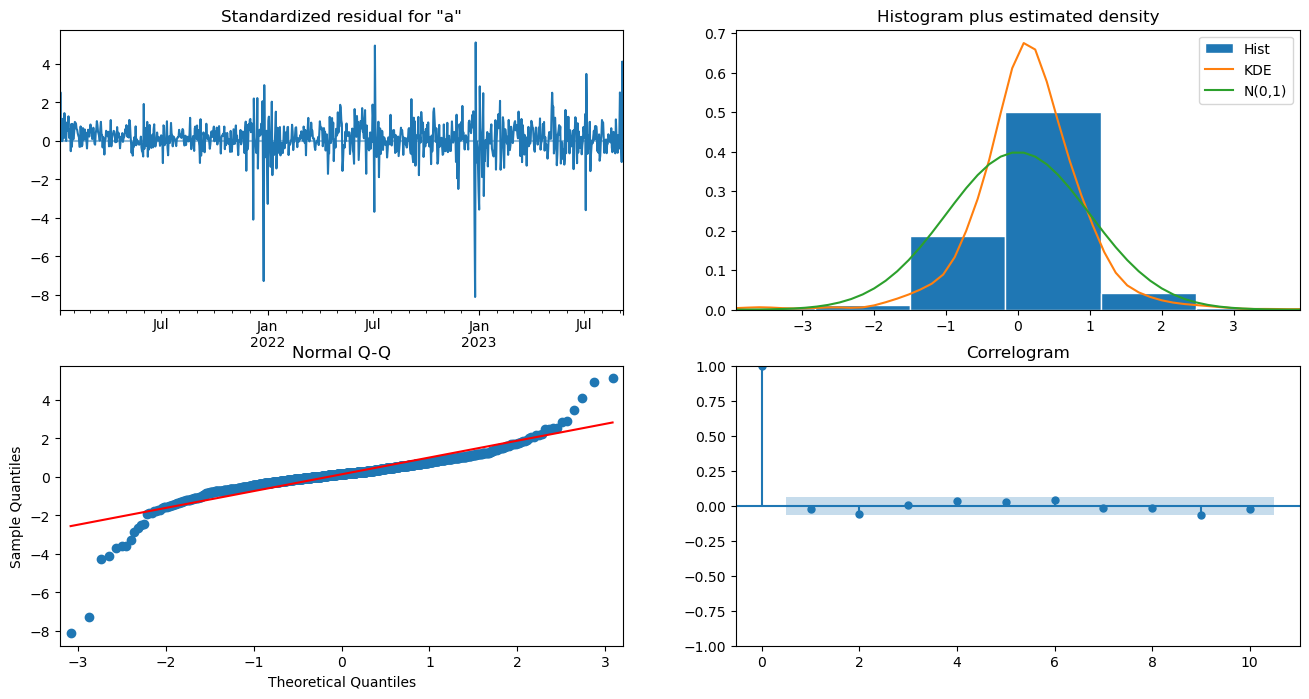

In [346]:
res2.plot_diagnostics(figsize=(16, 8))
plt.show()

In [347]:
testdata3=testdata3[0:20]
pred3 = res2.get_prediction(start=pd.to_datetime('2023-09-08'),end=pd.to_datetime('2023-09-27'), dynamic=False, exog=testdata3[exog3])
pred_test3 = pred3.conf_int()
res2 = pred3.predicted_mean
pred_test3["result"] = pred3.predicted_mean
pred_test3["y"] = testdata3['amount']
print("pred_test2:\n", pred_test3)

pred_test2:
             lower amount  upper amount        result            y
2023-09-08  1.011469e+07  1.333150e+07  1.172309e+07  12387078.39
2023-09-09  1.100656e+07  1.442625e+07  1.271640e+07  13750238.46
2023-09-10  9.963251e+06  1.344101e+07  1.170213e+07  12572008.55
2023-09-11  6.535440e+06  1.002660e+07  8.281021e+06   8069372.31
2023-09-12  5.552400e+06  9.046886e+06  7.299643e+06   6250790.48
2023-09-13  4.229033e+06  7.724331e+06  5.976682e+06   5772592.34
2023-09-14  4.989713e+06  8.485210e+06  6.737461e+06   6170513.15
2023-09-15  8.260801e+06  1.211884e+07  1.018982e+07   9829235.12
2023-09-16  9.414304e+06  1.331742e+07  1.136586e+07  11123317.16
2023-09-17  8.620569e+06  1.253695e+07  1.057876e+07  11274156.68
2023-09-18  6.245246e+06  1.016472e+07  8.204982e+06   8509119.31
2023-09-19  5.295029e+06  9.215270e+06  7.255149e+06   6343863.76
2023-09-20  4.304727e+06  8.225156e+06  6.264942e+06   5839099.60
2023-09-21  5.122567e+06  9.043042e+06  7.082805e+06   6300566.

In [348]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test3["ae"] = abs(pred_test3["y"]-pred_test3["result"])
mae = pred_test3["ae"].mean() 
print("mae:", mae)
mse = ((pred_test3["y"]-pred_test3["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test3["pe"] = abs((pred_test3["y"]-pred_test3["result"]) / pred_test3["y"])
mape = pred_test3["pe"].mean() 
print("mape:", mape)

wape = sum(pred_test3['ae']) / sum((pred_test3["y"]))
print("wape:", wape)

mae: 551284.8620635851
rmse: 645784.8510065895
mape: 0.06349682296303978
wape: 0.060246357200230104


In [349]:
##TESTEAMOS EFECTO DE LOS REZAGOS DEL PORCENTAJE DE CUPONES QUE SON PROMOCIONALES##


In [350]:
df_montos_mex3=df2.loc[df2.country=='MEXICO']

In [351]:
df_montos_mex3.amount.sum()

13655009099.176899

In [352]:
df_pilot5=df_montos_mex3.loc[df_montos_mex3.payer=='ELEKTRA (MEXICO)']
df_pilot5.shape

(1025, 7)

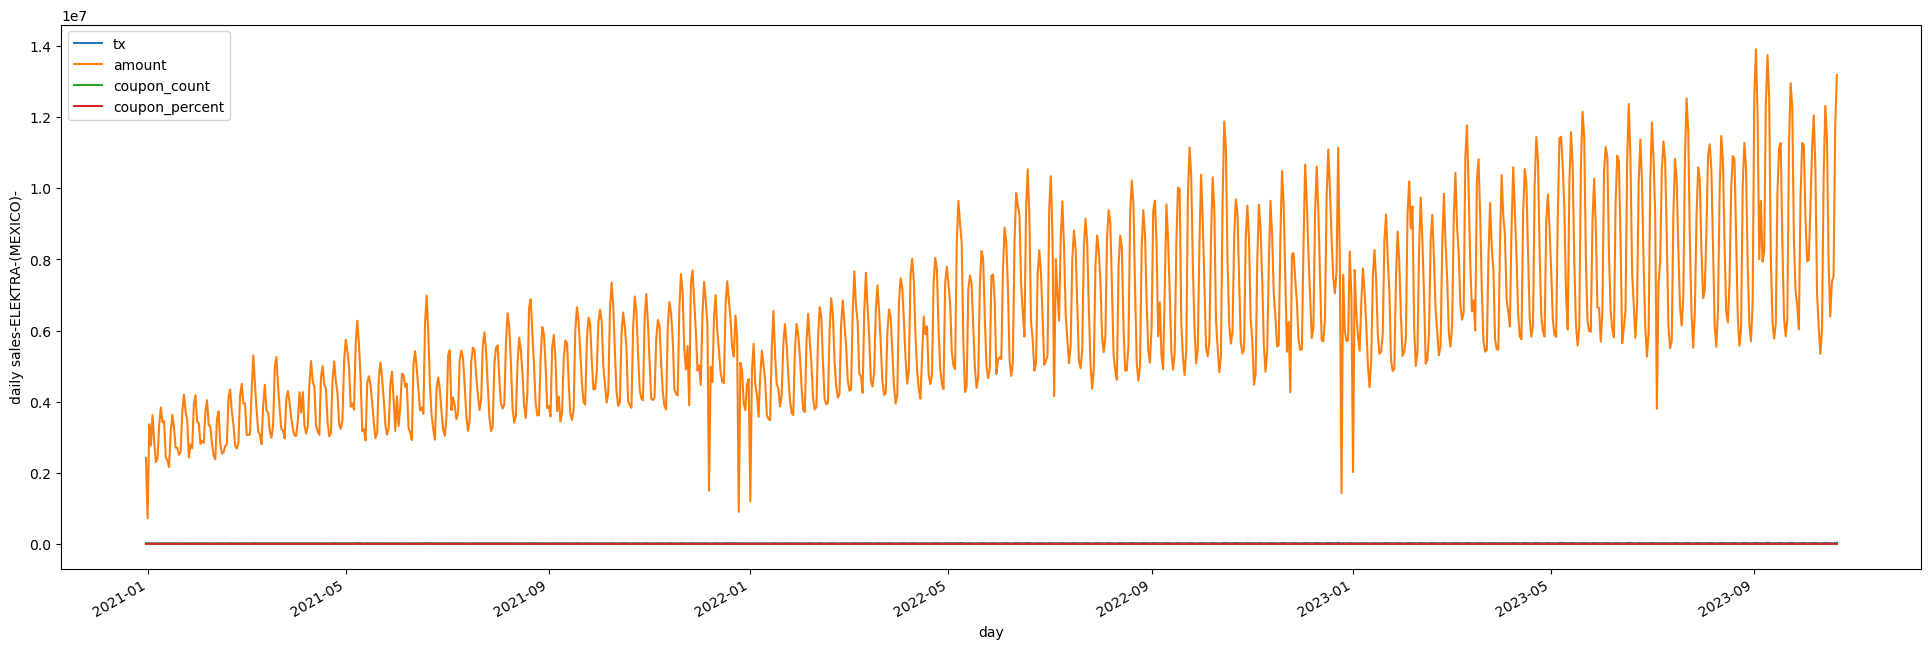

In [353]:
ax = df_pilot5.set_index('date').plot(figsize=(24, 8))
ax.set_ylabel('daily sales-ELEKTRA-(MEXICO)-')
ax.set_xlabel('day')
plt.show()

In [354]:
##TIME SERIES FORMAT
data = df_pilot5
data.dtypes #day object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot5.dtypes   # datetime64[ns]

data.index  #RangeIndex()
data = data.set_index('date')

In [355]:
data = data.sort_values(by='date')
data.head()

,payer,country,tx,amount,coupon_count,coupon_percent
date,,,,,,
2020-12-31,ELEKTRA (MEXICO),MEXICO,7698,2418346.71,6259,0.813068
2021-01-01,ELEKTRA (MEXICO),MEXICO,1998,717241.42,1534,0.767768
2021-01-02,ELEKTRA (MEXICO),MEXICO,8742,3360407.85,7067,0.808396
2021-01-03,ELEKTRA (MEXICO),MEXICO,7394,2767481.77,6028,0.815256
2021-01-04,ELEKTRA (MEXICO),MEXICO,8706,3621953.17,7030,0.807489


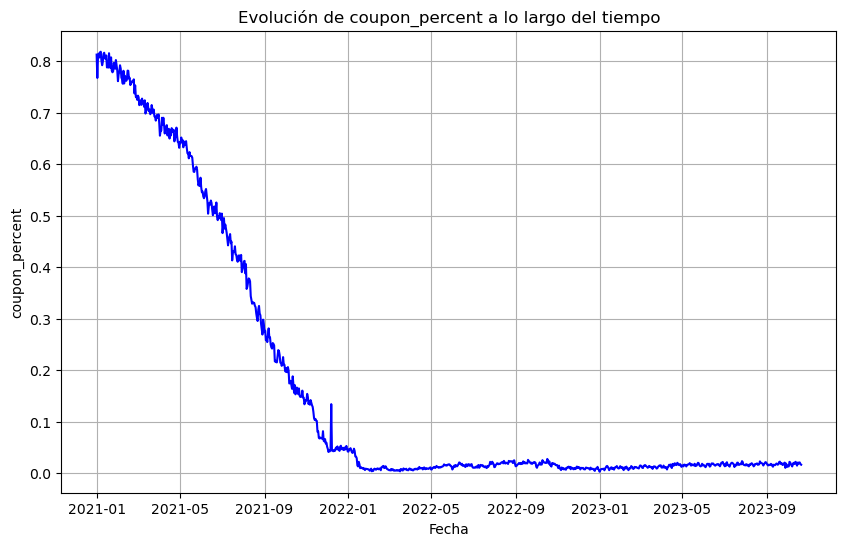

In [356]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['coupon_percent'], linestyle='-', color='b')

plt.title('Evolución de coupon_percent a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('coupon_percent')
plt.grid(True)
plt.show()

In [357]:
for i in range(1, 8):
        nombre_columna = f'coupon_percent_{i}'
        data[nombre_columna] = data['coupon_percent'].shift(i)

In [358]:
##WE ELIMINATE STRING VARIABLES AND OTHER VARIABLES##
##WE ELIMINATE STRING VARIABLES##
data=data.loc[:,['amount', 'coupon_percent_1', 'coupon_percent_2', 'coupon_percent_3', 'coupon_percent_4', 'coupon_percent_5', 'coupon_percent_6', 'coupon_percent_7']]

In [359]:
data.head()

,amount,coupon_percent_1,coupon_percent_2,coupon_percent_3,coupon_percent_4,coupon_percent_5,coupon_percent_6,coupon_percent_7
date,,,,,,,,
2020-12-31,2418346.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,717241.42,0.813068,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,3360407.85,0.767768,0.813068,NaN,NaN,NaN,NaN,NaN
2021-01-03,2767481.77,0.808396,0.767768,0.813068,NaN,NaN,NaN,NaN
2021-01-04,3621953.17,0.815256,0.808396,0.767768,0.813068,NaN,NaN,NaN


In [360]:
del data_rates_canc['amount']

In [361]:
data_rates_canc_coupon=pd.merge(data,data_rates_canc, left_index=True, right_index=True, how='left')

In [362]:
data_rates_canc_coupon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1025 entries, 2020-12-31 to 2023-10-21
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              1025 non-null   float64
 1   coupon_percent_1    1024 non-null   float64
 2   coupon_percent_2    1023 non-null   float64
 3   coupon_percent_3    1022 non-null   float64
 4   coupon_percent_4    1021 non-null   float64
 5   coupon_percent_5    1020 non-null   float64
 6   coupon_percent_6    1019 non-null   float64
 7   coupon_percent_7    1018 non-null   float64
 8   var_tx_cancelled_1  1025 non-null   float64
 9   var_tx_cancelled_2  1025 non-null   float64
 10  var_tx_cancelled_3  1025 non-null   float64
 11  var_tx_cancelled_4  1025 non-null   float64
 12  var_tx_cancelled_5  1025 non-null   float64
 13  var_tx_cancelled_6  1025 non-null   float64
 14  var_rate_lag1       1025 non-null   float64
 15  var_rate_lag2       1025 non-null   f

In [363]:
data_rates_canc_coupon.fillna(0, inplace=True)

In [364]:
traindata4 = data_rates_canc_coupon[0:981] #data[0:800]
traindata4.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07'],
              dtype='datetime64[ns]', name='date', length=981, freq=None)

In [365]:
testdata4 = data_rates_canc_coupon[981:1025] #data[0:1025]
testdata4.index

DatetimeIndex(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
               '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09',
               '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
               '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17',
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [366]:
traindata4.shape, testdata4.shape

((981, 20), (44, 20))

In [367]:
traindata4.head()

,amount,coupon_percent_1,coupon_percent_2,coupon_percent_3,coupon_percent_4,coupon_percent_5,coupon_percent_6,coupon_percent_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,,,,,,,,,,,,,,
2020-12-31,2418346.71,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-01,717241.42,0.813068,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-02,3360407.85,0.767768,0.813068,0.000000,0.000000,0.0,0.0,0.0,-184.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-03,2767481.77,0.808396,0.767768,0.813068,0.000000,0.0,0.0,0.0,264.0,-184.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2021-01-04,3621953.17,0.815256,0.808396,0.767768,0.813068,0.0,0.0,0.0,-80.0,264.0,-184.0,0.0,0.0,0.0,-0.054,0.0,0.0,0.0,0.0,0.0


In [368]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog4=['coupon_percent_1', 'coupon_percent_2', 'coupon_percent_3', 'coupon_percent_4','coupon_percent_5', 'coupon_percent_6','coupon_percent_7','var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6','var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6'] 
mod3 = sm.tsa.SARIMAX(traindata4[['amount']], order=(2,0,0), seasonal_order =(0, 1, 2, 7), exog=traindata4[exog4])
res3 = mod3.fit(maxiter=1000, disp=False)
print(res3.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  981
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -14536.339
Date:                                Mon, 05 Feb 2024   AIC                          29120.678
Time:                                        18:06:18   BIC                          29237.832
Sample:                                    12-31-2020   HQIC                         29165.262
                                         - 09-07-2023                                         
Covariance Type:                                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
coupon_percent_1   -3.393e+06   9.64e+04    -35.190      0.000   -

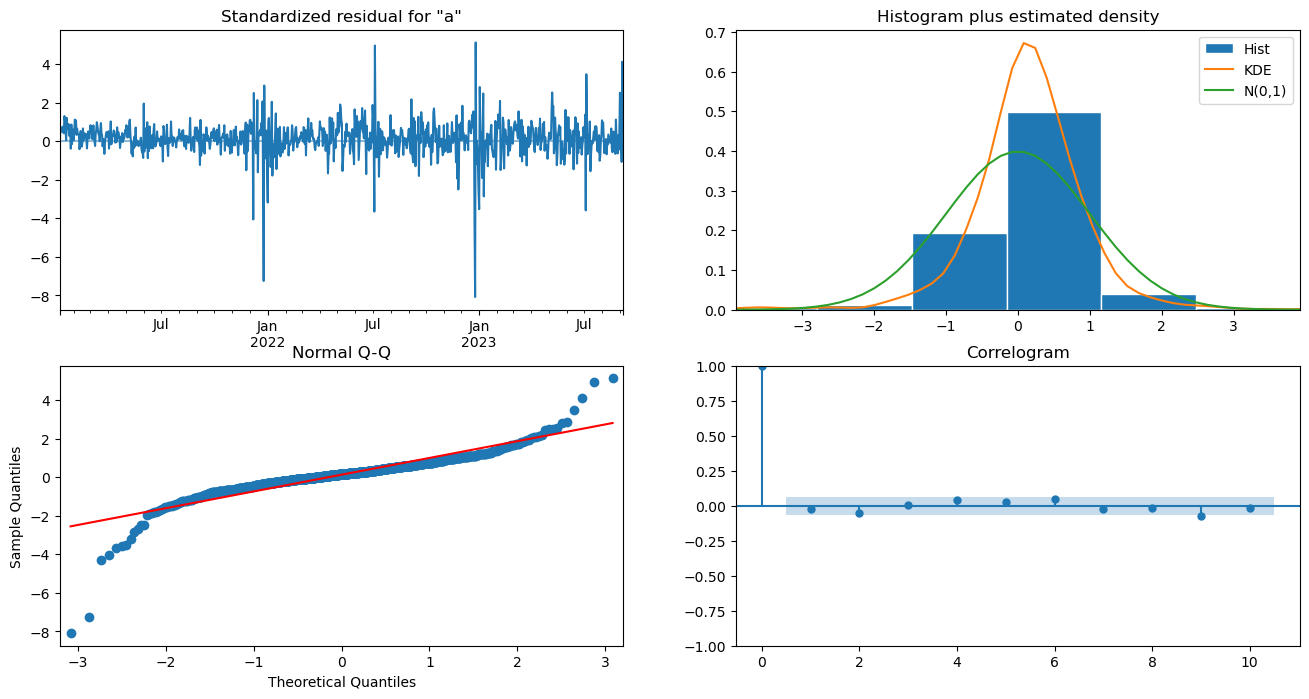

In [369]:
res3.plot_diagnostics(figsize=(16, 8))
plt.show()

In [370]:
testdata4=testdata4[0:20]
pred4 = res3.get_prediction(start=pd.to_datetime('2023-09-08'),end=pd.to_datetime('2023-09-27'), dynamic=False, exog=testdata4[exog4])
pred_test4 = pred4.conf_int()
res3 = pred4.predicted_mean
pred_test4["result"] = pred4.predicted_mean
pred_test4["y"] = testdata4['amount']
print("pred_test4:\n", pred_test4)

pred_test4:
             lower amount  upper amount        result            y
2023-09-08  1.010207e+07  1.331775e+07  1.170991e+07  12387078.39
2023-09-09  1.100213e+07  1.441990e+07  1.271101e+07  13750238.46
2023-09-10  9.968643e+06  1.344140e+07  1.170502e+07  12572008.55
2023-09-11  6.519688e+06  1.000480e+07  8.262245e+06   8069372.31
2023-09-12  5.546656e+06  9.034726e+06  7.290691e+06   6250790.48
2023-09-13  4.239332e+06  7.728101e+06  5.983717e+06   5772592.34
2023-09-14  4.991346e+06  8.480280e+06  6.735813e+06   6170513.15
2023-09-15  8.237158e+06  1.208342e+07  1.016029e+07   9829235.12
2023-09-16  9.401311e+06  1.329181e+07  1.134656e+07  11123317.16
2023-09-17  8.627480e+06  1.253036e+07  1.057892e+07  11274156.68
2023-09-18  6.250608e+06  1.015630e+07  8.203453e+06   8509119.31
2023-09-19  5.286226e+06  9.192589e+06  7.239407e+06   6343863.76
2023-09-20  4.309118e+06  8.215640e+06  6.262379e+06   5839099.60
2023-09-21  5.116253e+06  9.022812e+06  7.069532e+06   6300566.

In [371]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test4["ae"] = abs(pred_test4["y"]-pred_test4["result"])
mae = pred_test4["ae"].mean() 
print("mae:", mae)
mse = ((pred_test4["y"]-pred_test4["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test4["pe"] = abs((pred_test4["y"]-pred_test4["result"]) / pred_test4["y"])
mape = pred_test4["pe"].mean() 
print("mape:", mape)

wape = sum(pred_test4['ae']) / sum((pred_test4["y"]))
print("wape:", wape)

mae: 547271.315664532
rmse: 643319.0387781966
mape: 0.06289825715925898
wape: 0.05980774267145105


In [372]:
###AGREGAMOS DIAS ESPECIALES EN ESTE ESQUEMA DE MODELADO##

In [373]:
data_rates_canc_coupon['date']=data_rates_canc_coupon.index

In [374]:
data_rates_canc_coupon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1025 entries, 2020-12-31 to 2023-10-21
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   amount              1025 non-null   float64       
 1   coupon_percent_1    1025 non-null   float64       
 2   coupon_percent_2    1025 non-null   float64       
 3   coupon_percent_3    1025 non-null   float64       
 4   coupon_percent_4    1025 non-null   float64       
 5   coupon_percent_5    1025 non-null   float64       
 6   coupon_percent_6    1025 non-null   float64       
 7   coupon_percent_7    1025 non-null   float64       
 8   var_tx_cancelled_1  1025 non-null   float64       
 9   var_tx_cancelled_2  1025 non-null   float64       
 10  var_tx_cancelled_3  1025 non-null   float64       
 11  var_tx_cancelled_4  1025 non-null   float64       
 12  var_tx_cancelled_5  1025 non-null   float64       
 13  var_tx_cancelled_6  1025 non-n

In [375]:
#WE ADD ONE MORE DAY AFTER CHRISTMAS, NEW YEAR'S EVE AND US INDEPENDENCE (BETTER CAPTURES THE DISTURBANCE).
# Special dates list - Format: Month-day 
special_dates_list = [ '07-04', #US independence day 
                      '07-05',
                      '07-06',
                      '12-25', #Christmas
                      '05-11' # Mexico & Colombia - Mother's day
                     '01-01', #New Year
                     '01-02',
                     '12-26',
                     '12-27',
                     ] 

# Applying format process special_dates function
special_dates_list_processed = [(int(date.split('-')[0]), int(date.split('-')[1])) for date in special_dates_list]

In [376]:
# To check special dates defined by list
def mark_special_dates(row):
    if (row['date'].month, row['date'].day) in special_dates_list_processed:
        return 1
    else:
        return 0

In [377]:
# Marking special dates in df
data_rates_canc_coupon['special_dates'] = data_rates_canc_coupon.apply(lambda row: mark_special_dates(row), axis=1)

In [378]:
data_rates_canc_coupon.head()

,amount,coupon_percent_1,coupon_percent_2,coupon_percent_3,coupon_percent_4,coupon_percent_5,coupon_percent_6,coupon_percent_7,var_tx_cancelled_1,var_tx_cancelled_2,...,var_tx_cancelled_5,var_tx_cancelled_6,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,date,special_dates
date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,2418346.71,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2020-12-31,0
2021-01-01,717241.42,0.813068,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2021-01-01,0
2021-01-02,3360407.85,0.767768,0.813068,0.000000,0.000000,0.0,0.0,0.0,-184.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2021-01-02,1
2021-01-03,2767481.77,0.808396,0.767768,0.813068,0.000000,0.0,0.0,0.0,264.0,-184.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2021-01-03,0
2021-01-04,3621953.17,0.815256,0.808396,0.767768,0.813068,0.0,0.0,0.0,-80.0,264.0,...,0.0,0.0,-0.054,0.0,0.0,0.0,0.0,0.0,2021-01-04,0


In [379]:
### DUMMIES ####

# Weekend indicator (dummy)
data_rates_canc_coupon['weekend'] = (data_rates_canc_coupon['date'].dt.dayofweek >= 4).astype(int)

In [380]:
traindata5 = data_rates_canc_coupon[0:981] #data[0:800]
traindata5.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07'],
              dtype='datetime64[ns]', name='date', length=981, freq=None)

In [381]:
testdata5 = data_rates_canc_coupon[981:1025] #data[0:1025]
testdata5.index

DatetimeIndex(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
               '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09',
               '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
               '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17',
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [382]:
traindata5.shape, testdata5.shape

((981, 23), (44, 23))

In [383]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog5=['coupon_percent_1', 'coupon_percent_2', 'coupon_percent_3', 'coupon_percent_4','coupon_percent_5', 'coupon_percent_6','coupon_percent_7','var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6','var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6', 'special_dates'] 
mod4 = sm.tsa.SARIMAX(traindata5[['amount']], order=(2,0,0), seasonal_order =(0, 1, 2, 7), exog=traindata5[exog5])
res4 = mod4.fit(maxiter=1000, disp=False)
print(res4.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  981
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -14533.108
Date:                                Mon, 05 Feb 2024   AIC                          29116.217
Time:                                        18:06:25   BIC                          29238.252
Sample:                                    12-31-2020   HQIC                         29162.658
                                         - 09-07-2023                                         
Covariance Type:                                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
coupon_percent_1   -3.378e+06   9.73e+04    -34.721      0.000   -

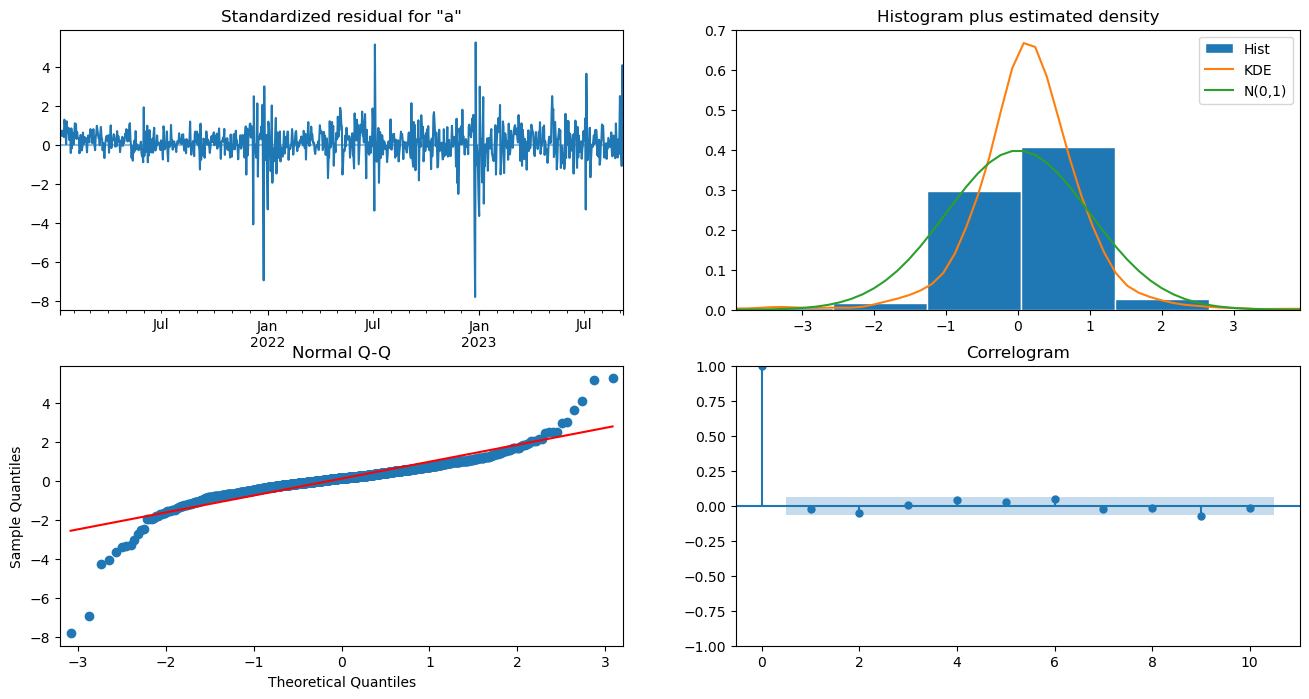

In [384]:
res4.plot_diagnostics(figsize=(16, 8))
plt.show()

In [385]:
testdata5=testdata5[0:20]
pred5 = res4.get_prediction(start=pd.to_datetime('2023-09-08'),end=pd.to_datetime('2023-09-27'), dynamic=False, exog=testdata5[exog5])
pred_test5 = pred5.conf_int()
res4 = pred5.predicted_mean
pred_test5["result"] = pred5.predicted_mean
pred_test5["y"] = testdata5['amount']
print("pred_test5:\n", pred_test5)

pred_test5:
             lower amount  upper amount        result            y
2023-09-08  1.011044e+07  1.331696e+07  1.171370e+07  12387078.39
2023-09-09  1.102845e+07  1.444118e+07  1.273482e+07  13750238.46
2023-09-10  9.974139e+06  1.344237e+07  1.170825e+07  12572008.55
2023-09-11  6.504616e+06  9.985387e+06  8.245001e+06   8069372.31
2023-09-12  5.553010e+06  9.036783e+06  7.294896e+06   6250790.48
2023-09-13  4.270006e+06  7.754490e+06  6.012248e+06   5772592.34
2023-09-14  5.008811e+06  8.493464e+06  6.751138e+06   6170513.15
2023-09-15  8.234674e+06  1.207424e+07  1.015446e+07   9829235.12
2023-09-16  9.407080e+06  1.329164e+07  1.134936e+07  11123317.16
2023-09-17  8.635994e+06  1.253302e+07  1.058450e+07  11274156.68
2023-09-18  6.250212e+06  1.015007e+07  8.200143e+06   8509119.31
2023-09-19  5.285314e+06  9.185858e+06  7.235586e+06   6343863.76
2023-09-20  4.319931e+06  8.220637e+06  6.270284e+06   5839099.60
2023-09-21  5.132105e+06  9.032849e+06  7.082477e+06   6300566.

In [386]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test5["ae"] = abs(pred_test5["y"]-pred_test5["result"])
mae = pred_test5["ae"].mean() 
print("mae:", mae)
mse = ((pred_test5["y"]-pred_test5["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test5["pe"] = abs((pred_test5["y"]-pred_test5["result"]) / pred_test5["y"])
mape = pred_test5["pe"].mean() 
print("mape:", mape)

wape = sum(pred_test5['ae']) / sum((pred_test5["y"]))
print("wape:", wape)

mae: 548307.5519224262
rmse: 643566.660902987
mape: 0.06323139385922719
wape: 0.05992098623033136


In [387]:
### IMPUTAR PERCENTIL 99 Y MAS ?

In [388]:
import numpy as np
percentile_98 = np.percentile(data_rates_canc_coupon.amount, 98)
data_rates_canc_coupon[data_rates_canc_coupon.amount > percentile_98] = np.mean(data_rates_canc_coupon.amount)

In [389]:
traindata6 = data_rates_canc_coupon[0:981] #data[0:800]
traindata6.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07'],
              dtype='datetime64[ns]', name='date', length=981, freq=None)

In [390]:
testdata6 = data_rates_canc_coupon[981:1025] #data[0:1025]
testdata6.index

DatetimeIndex(['2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15',
               '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23',
               '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
               '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09',
               '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13',
               '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17',
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [391]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog5=['coupon_percent_1', 'coupon_percent_2', 'coupon_percent_3', 'coupon_percent_4','coupon_percent_5', 'coupon_percent_6','coupon_percent_7','var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6','var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6', 'special_dates'] 
mod5 = sm.tsa.SARIMAX(traindata6[['amount']], order=(2,0,0), seasonal_order =(0, 1, 2, 7), exog=traindata6[exog5])
res5 = mod5.fit(maxiter=1000, disp=False)
print(res5.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  981
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -14529.124
Date:                                Mon, 05 Feb 2024   AIC                          29108.248
Time:                                        18:06:32   BIC                          29230.283
Sample:                                    12-31-2020   HQIC                         29154.689
                                         - 09-07-2023                                         
Covariance Type:                                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
coupon_percent_1   -5.517e+06   8.19e+04    -67.351      0.000   -

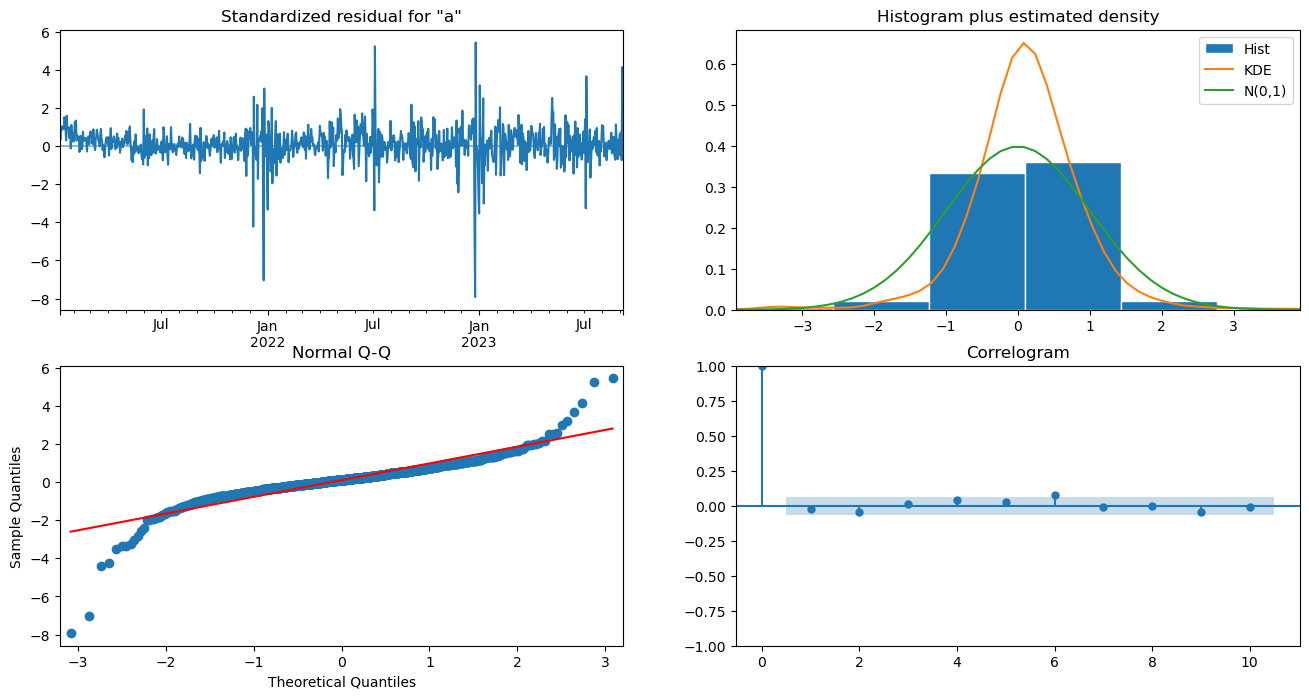

In [392]:
res5.plot_diagnostics(figsize=(16, 8))
plt.show()

In [393]:
testdata6=testdata6[0:20]
pred6 = res5.get_prediction(start=pd.to_datetime('2023-09-08'),end=pd.to_datetime('2023-09-27'), dynamic=False, exog=testdata6[exog5])
pred_test6 = pred6.conf_int()
res5 = pred6.predicted_mean
pred_test6["result"] = pred6.predicted_mean
pred_test6["y"] = testdata6['amount']
print("pred_test6:\n", pred_test6)

pred_test6:
             lower amount  upper amount        result             y
2023-09-08  4.637036e+06  7.816785e+06  6.226910e+06  6.241899e+06
2023-09-09  4.743350e+06  8.132512e+06  6.437931e+06  6.241899e+06
2023-09-10  4.333907e+06  7.802359e+06  6.068133e+06  6.241899e+06
2023-09-11  6.506794e+06  9.996482e+06  8.251638e+06  8.069372e+06
2023-09-12  5.634556e+06  9.130706e+06  7.382631e+06  6.250790e+06
2023-09-13  4.394673e+06  7.892721e+06  6.143697e+06  5.772592e+06
2023-09-14  5.105674e+06  8.604287e+06  6.854980e+06  6.170513e+06
2023-09-15  7.928009e+06  1.178712e+07  9.857565e+06  9.829235e+06
2023-09-16  8.655085e+06  1.256161e+07  1.060835e+07  1.112332e+07
2023-09-17  8.612563e+06  1.253751e+07  1.057504e+07  1.127416e+07
2023-09-18  6.268639e+06  1.019859e+07  8.233617e+06  8.509119e+06
2023-09-19  5.262718e+06  9.194199e+06  7.228458e+06  6.343864e+06
2023-09-20  4.341843e+06  8.273774e+06  6.307809e+06  5.839100e+06
2023-09-21  5.113505e+06  9.045569e+06  7.079537e

In [487]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test6["ae"] = abs(pred_test6["y"]-pred_test6["result"])
mae = pred_test6["ae"].mean() 
print("mae:", mae)
mse = ((pred_test6["y"]-pred_test6["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test6["pe"] = abs((pred_test6["y"]-pred_test6["result"]) / pred_test6["y"])
mape = pred_test6["pe"].mean() 
print("mape:", mape)
wape = sum(pred_test6['ae']) / sum((pred_test6["y"]))
print("wape:", wape)

mae: 400969.9713973282
rmse: 511364.45246217976
mape: 0.05664729930220005
wape: 0.053364854232268215


In [ ]:
##OJO QUE EL ERROR MAS BAJO DE ARRIBA ESTÁ INDUCIDO POR IMPUTAR TAMBIEN EN TEST VALORES EXTREMOS